In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

In [2]:
df_energy = pd.read_csv(
'./Dataset/energy_dataset.csv',
parse_dates=['time'])

In [3]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [4]:
# Drop unusable columns

df_energy = df_energy.drop(['generation fossil coal-derived gas',
                           'generation fossil oil shale',
                           'generation fossil peat', 
                            'generation geothermal',
            'generation hydro pumped storage aggregated', 
            'generation marine', 'generation wind offshore',
        'forecast wind offshore eday ahead', 'total load forecast',
        'forecast solar day ahead', 'forecast wind onshore day ahead'],
                          axis=1)

In [5]:
df_energy.describe().round(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
count,35045.00,35046.00,35046.00,35046.00,35045.00,35045.00,35045.00,35046.00,35047.00,35046.00,35046.00,35046.00,35045.00,35046.00,35028.00,35064.00,35064.00
mean,383.51,448.06,5622.74,4256.07,298.32,475.58,972.12,2605.11,6263.91,60.23,85.64,1432.67,269.45,5464.48,28696.94,49.87,57.88
std,85.35,354.57,2201.83,1961.60,52.52,792.41,400.78,1835.20,839.67,20.24,14.08,1680.12,50.20,3213.69,4574.99,14.62,14.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18041.00,2.06,9.33
25%,333.00,0.00,4126.00,2527.00,263.00,0.00,637.00,1077.25,5760.00,53.00,73.00,71.00,240.00,2933.00,24807.75,41.49,49.35
50%,367.00,509.00,4969.00,4474.00,300.00,68.00,906.00,2164.00,6566.00,57.00,88.00,616.00,279.00,4849.00,28901.00,50.52,58.02
75%,433.00,757.00,6429.00,5838.75,330.00,616.00,1250.00,3757.00,7025.00,80.00,97.00,2578.00,310.00,7398.00,32192.00,60.53,68.01
max,592.00,999.00,20034.00,8359.00,449.00,4523.00,2000.00,9728.00,7117.00,106.00,119.00,5792.00,357.00,17436.00,41015.00,101.99,116.80


In [6]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [7]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04


In [8]:
# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'],
                                  utc=True, 
                            infer_datetime_format = True)
df_energy = df_energy.set_index('time')

In [9]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'.format(
df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'.format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [10]:
# Number of NaNs in each column

df_energy.isnull().sum(axis=0).sort_values(ascending=False)

total load actual                              36
generation biomass                             19
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation waste                               19
generation fossil gas                          18
generation fossil hard coal                    18
generation hydro water reservoir               18
generation fossil brown coal/lignite           18
generation other                               18
generation other renewable                     18
generation solar                               18
generation wind onshore                        18
generation nuclear                             17
price day ahead                                 0
price actual                                    0
dtype: int64

In [11]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]),
               label=None, ylabel=None, title=None, start=0,
               end=None):
    
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it is a custom pandas 
    series created by the user. The user can define either th e'df' and the 'column'
    or the 'series' and additionally, can also define the 'label',
    the 'ylabel', the 'title', the 'start' and the end of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30,12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
        
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

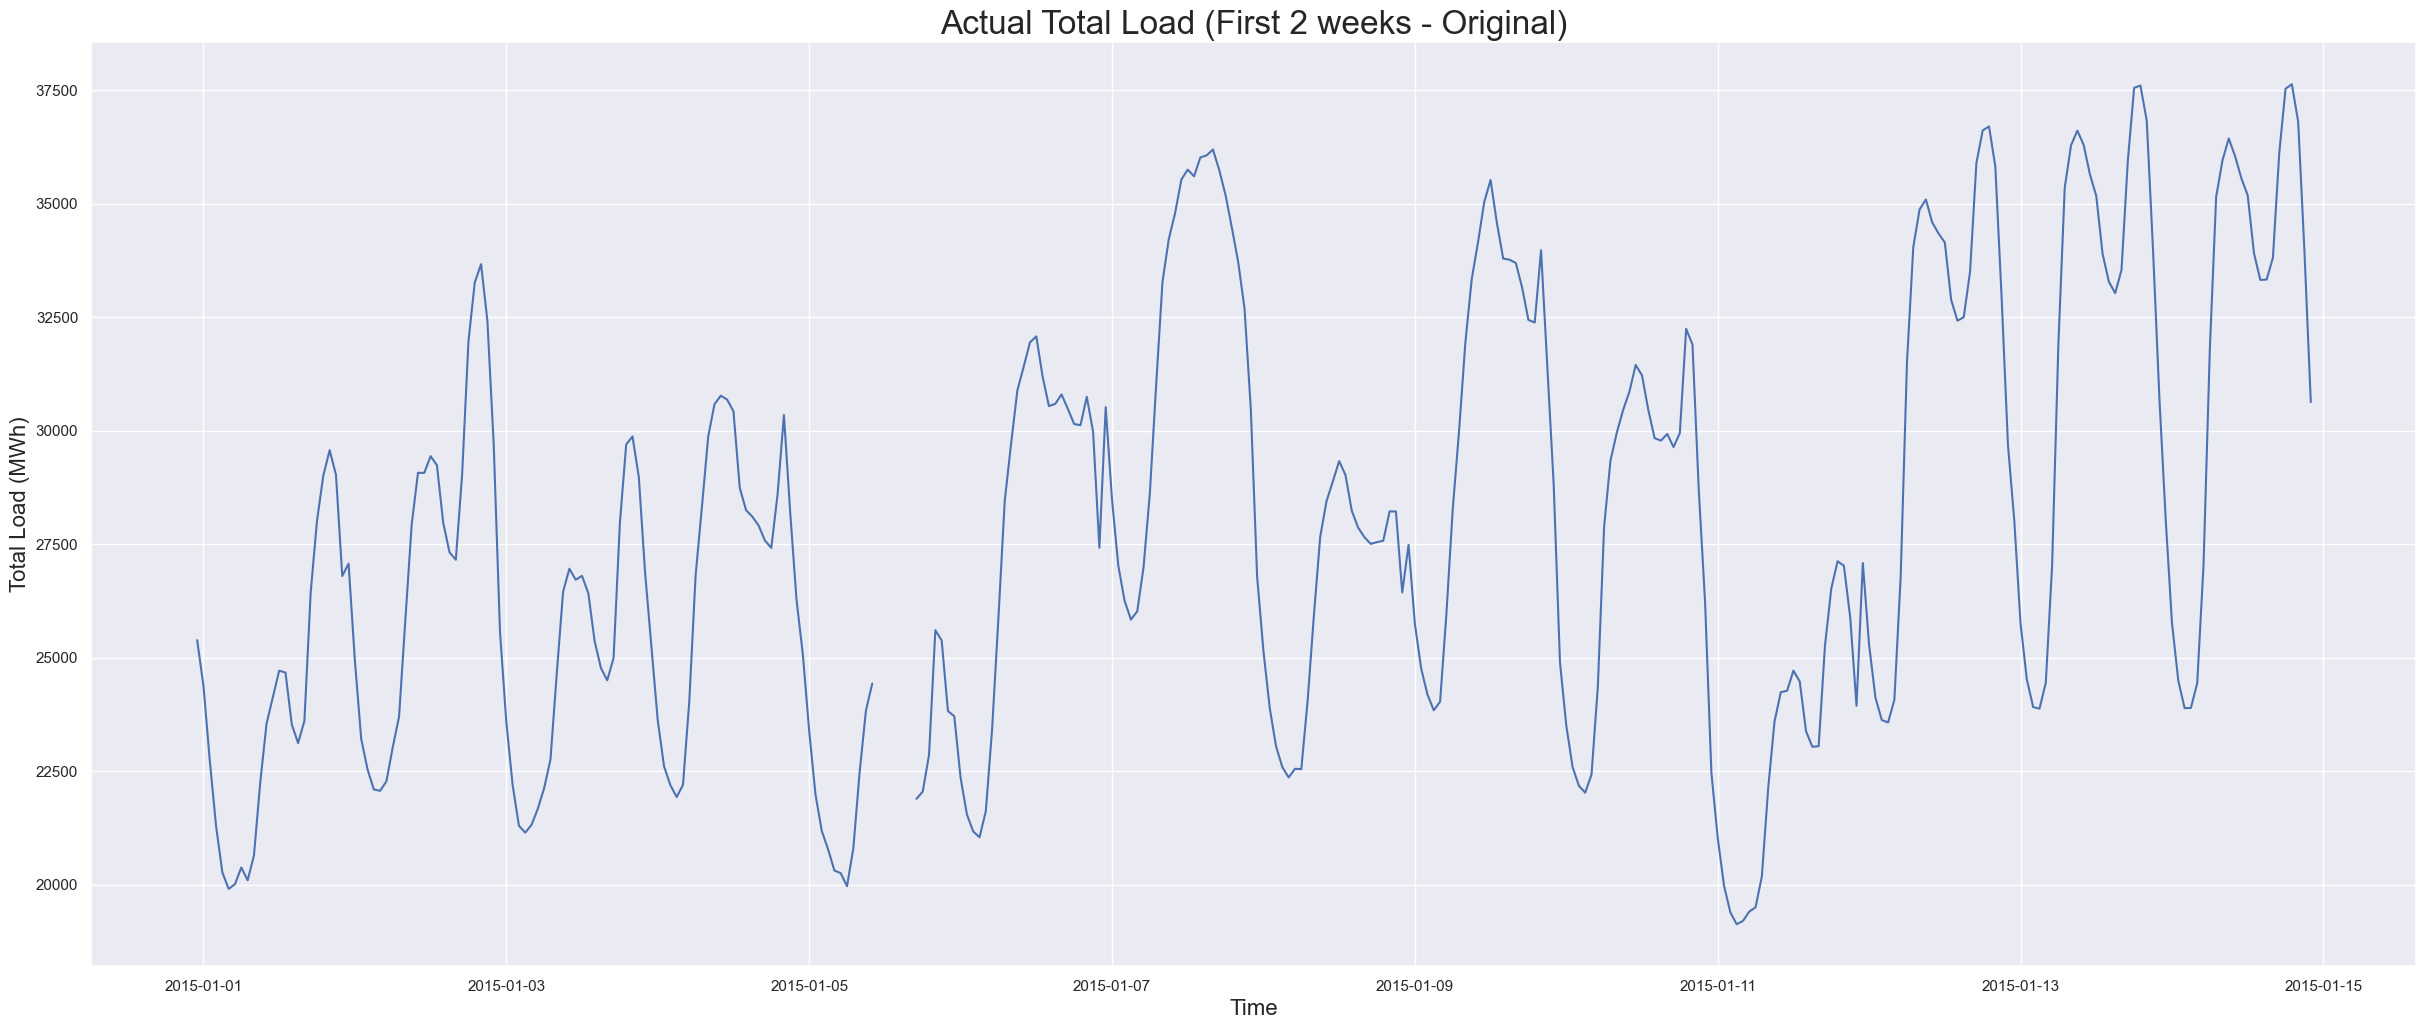

In [12]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_energy, column='total load actual', ylabel=
                'Total Load (MWh)',
            title='Actual Total Load (First 2 weeks - Original)',
            end=24*7*2)
plt.show()

In [13]:
df_energy[df_energy['total load actual'].isnull()]

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2015-01-05 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.50,79.14
2015-01-05 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.80,73.95
2015-01-05 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.50,71.93
2015-01-05 14:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,71.50
2015-01-05 15:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,71.85
2015-01-05 16:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.60,80.53
2015-01-28 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.00,77.62
2015-02-01 06:00:00+00:00,449.0,312.0,4765.0,5269.0,222.0,480.0,980.0,1174.0,7101.0,44.0,75.0,48.0,208.0,3289.0,NaN,56.10,16.98
2015-02-01 07:00:00+00:00,453.0,312.0,4938.0,5652.0,288.0,0.0,1031.0,3229.0,7099.0,44.0,75.0,73.0,207.0,3102.0,NaN,57.69,19.56


After zooming into the first 2 weeks of the 'total load actual' column, we can already see that there are null values for afew hours. However, the number of the missing values and the behaviour of the series indicate that an interpolation would fill the NaNs quite well. Let us further investigate if the null values coincide across the different columns. Let us display the last five rows.

In [14]:
# Display the rows with null values

df_energy[df_energy.isnull().any(axis=1)].tail()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2016-11-23 03:00:00+00:00,NaN,900.0,4838.0,4547.0,269.0,1413.0,795.0,435.0,5040.0,60.0,85.0,15.0,227.0,4598.0,23112.0,43.19,49.11
2017-11-14 11:00:00+00:00,0.0,0.0,10064.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,60.53,66.17
2017-11-14 18:00:00+00:00,0.0,0.0,12336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,68.05,75.45
2018-06-11 16:00:00+00:00,331.0,506.0,7538.0,5360.0,300.0,1.0,1134.0,4258.0,5856.0,52.0,96.0,170.0,269.0,9165.0,NaN,69.87,64.93
2018-07-11 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.01,69.79


If we manually searched through all of them, we could confirm that the null values in the columns which have to do with the typ eof energy generation mostly coincide. The null values in 'actual total load' also coincide with the aforementioned columns, but also appear in other rows as well. In order to handle the null values in df_energy, we will use a linear interpolation with a forward direction. Perhaps other kinds of interpolation would be better; nevertheless, we prefer to use the simplest model possible. Only a small part of our input data will be noisy and it will not affect performance noticeably.

In [15]:
# Fill null values using interpolation

df_energy.interpolate(method='linear', limit_direction='forward',
                inplace=True, axis=0)

In [16]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_energy.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

generation biomass                             35060
generation fossil brown coal/lignite           24540
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22450
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
total load actual                              35064
price day ahead                                35064
price actual                                   35064
dtype: int64


In [17]:
# Define a function which will calculate R-squared score for the same column in two datframes

def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("R-Squared score of {} is {}".format(column, r2.round(3)))

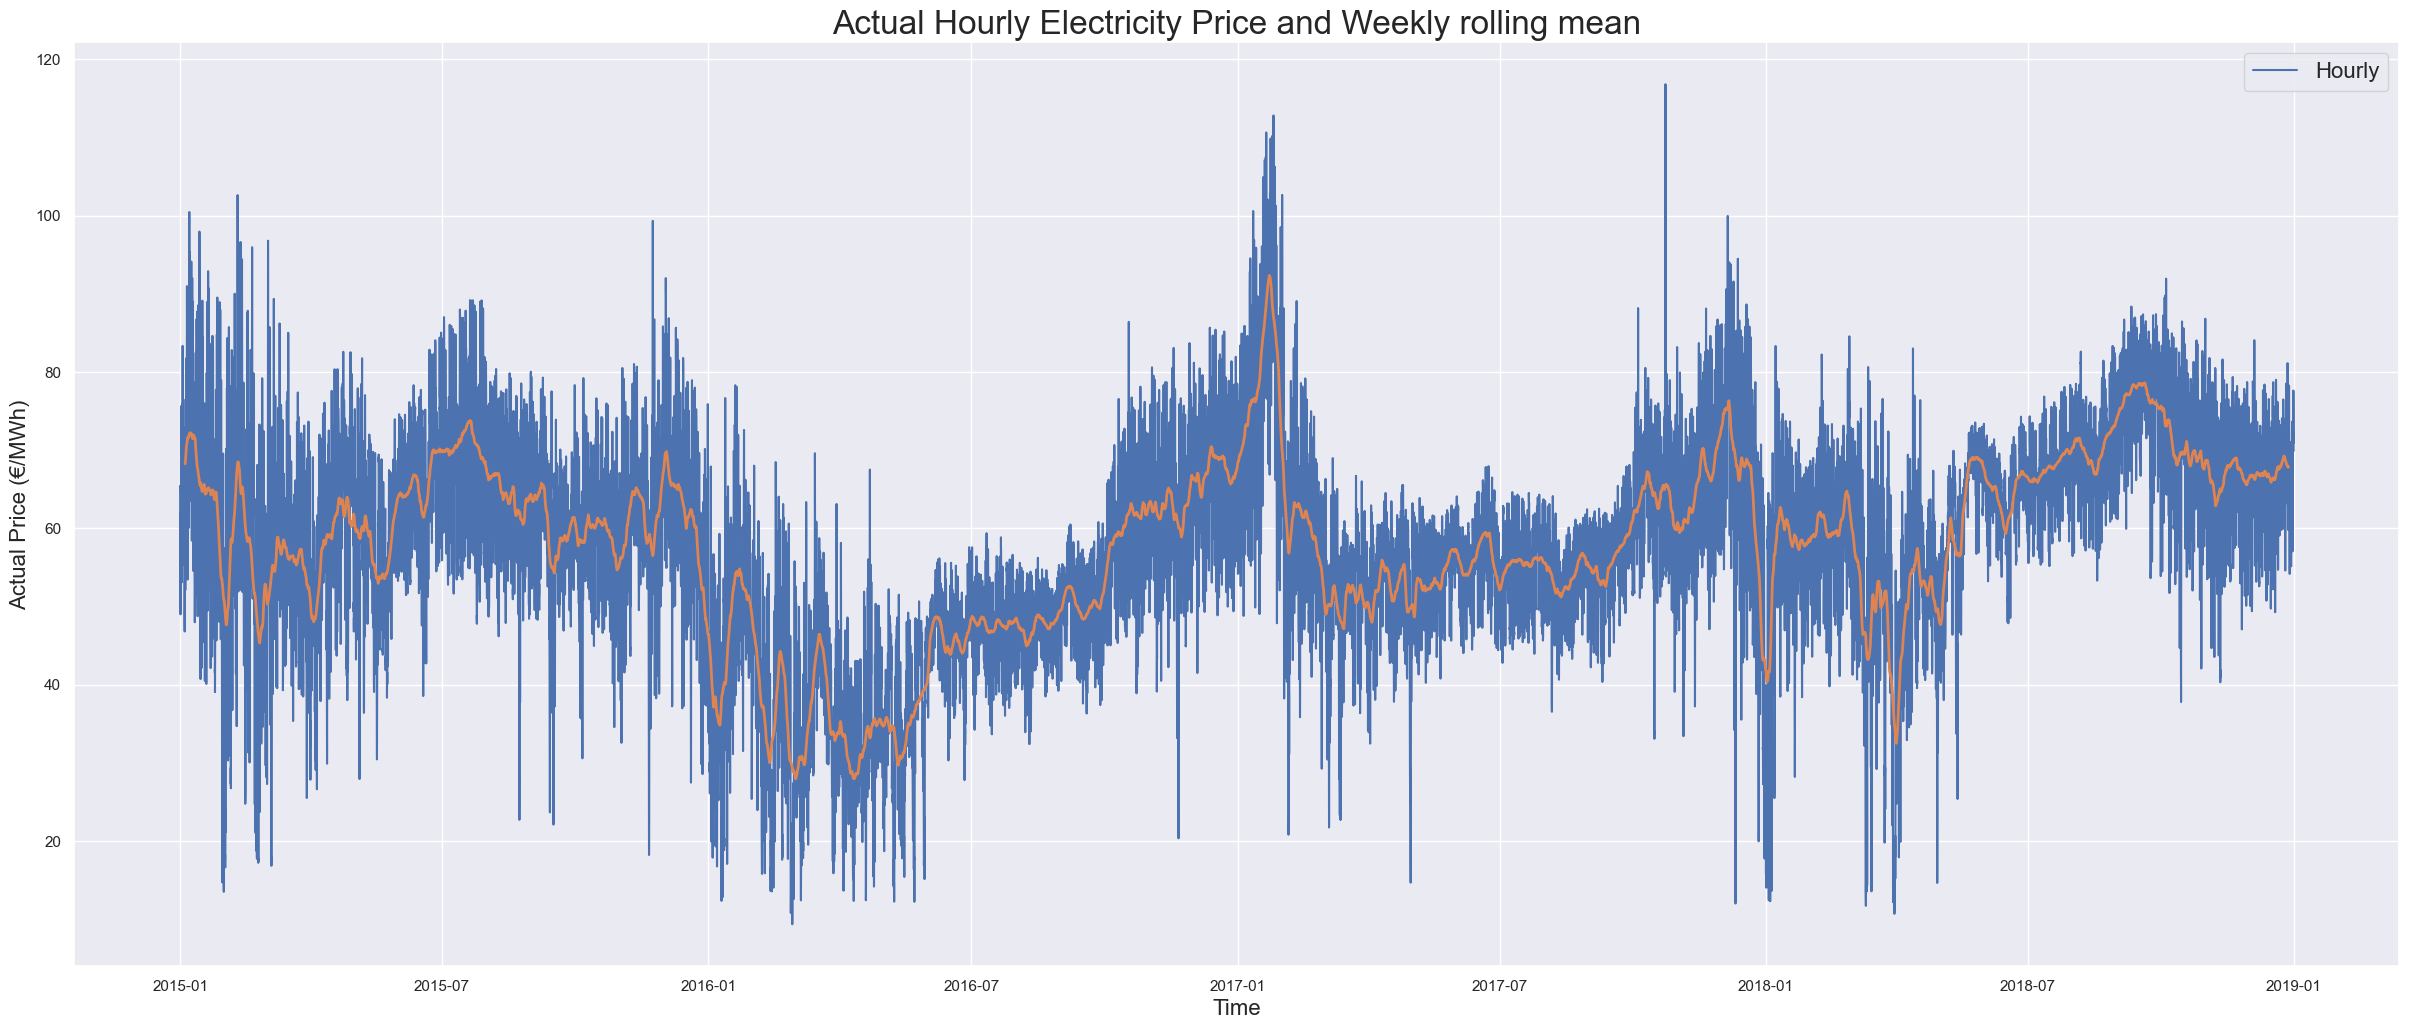

In [20]:
# Define df_final if not already defined
df_final = df_energy.copy()

# Plot the hourly actual electricity price, along with the weekly rolling mean
rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

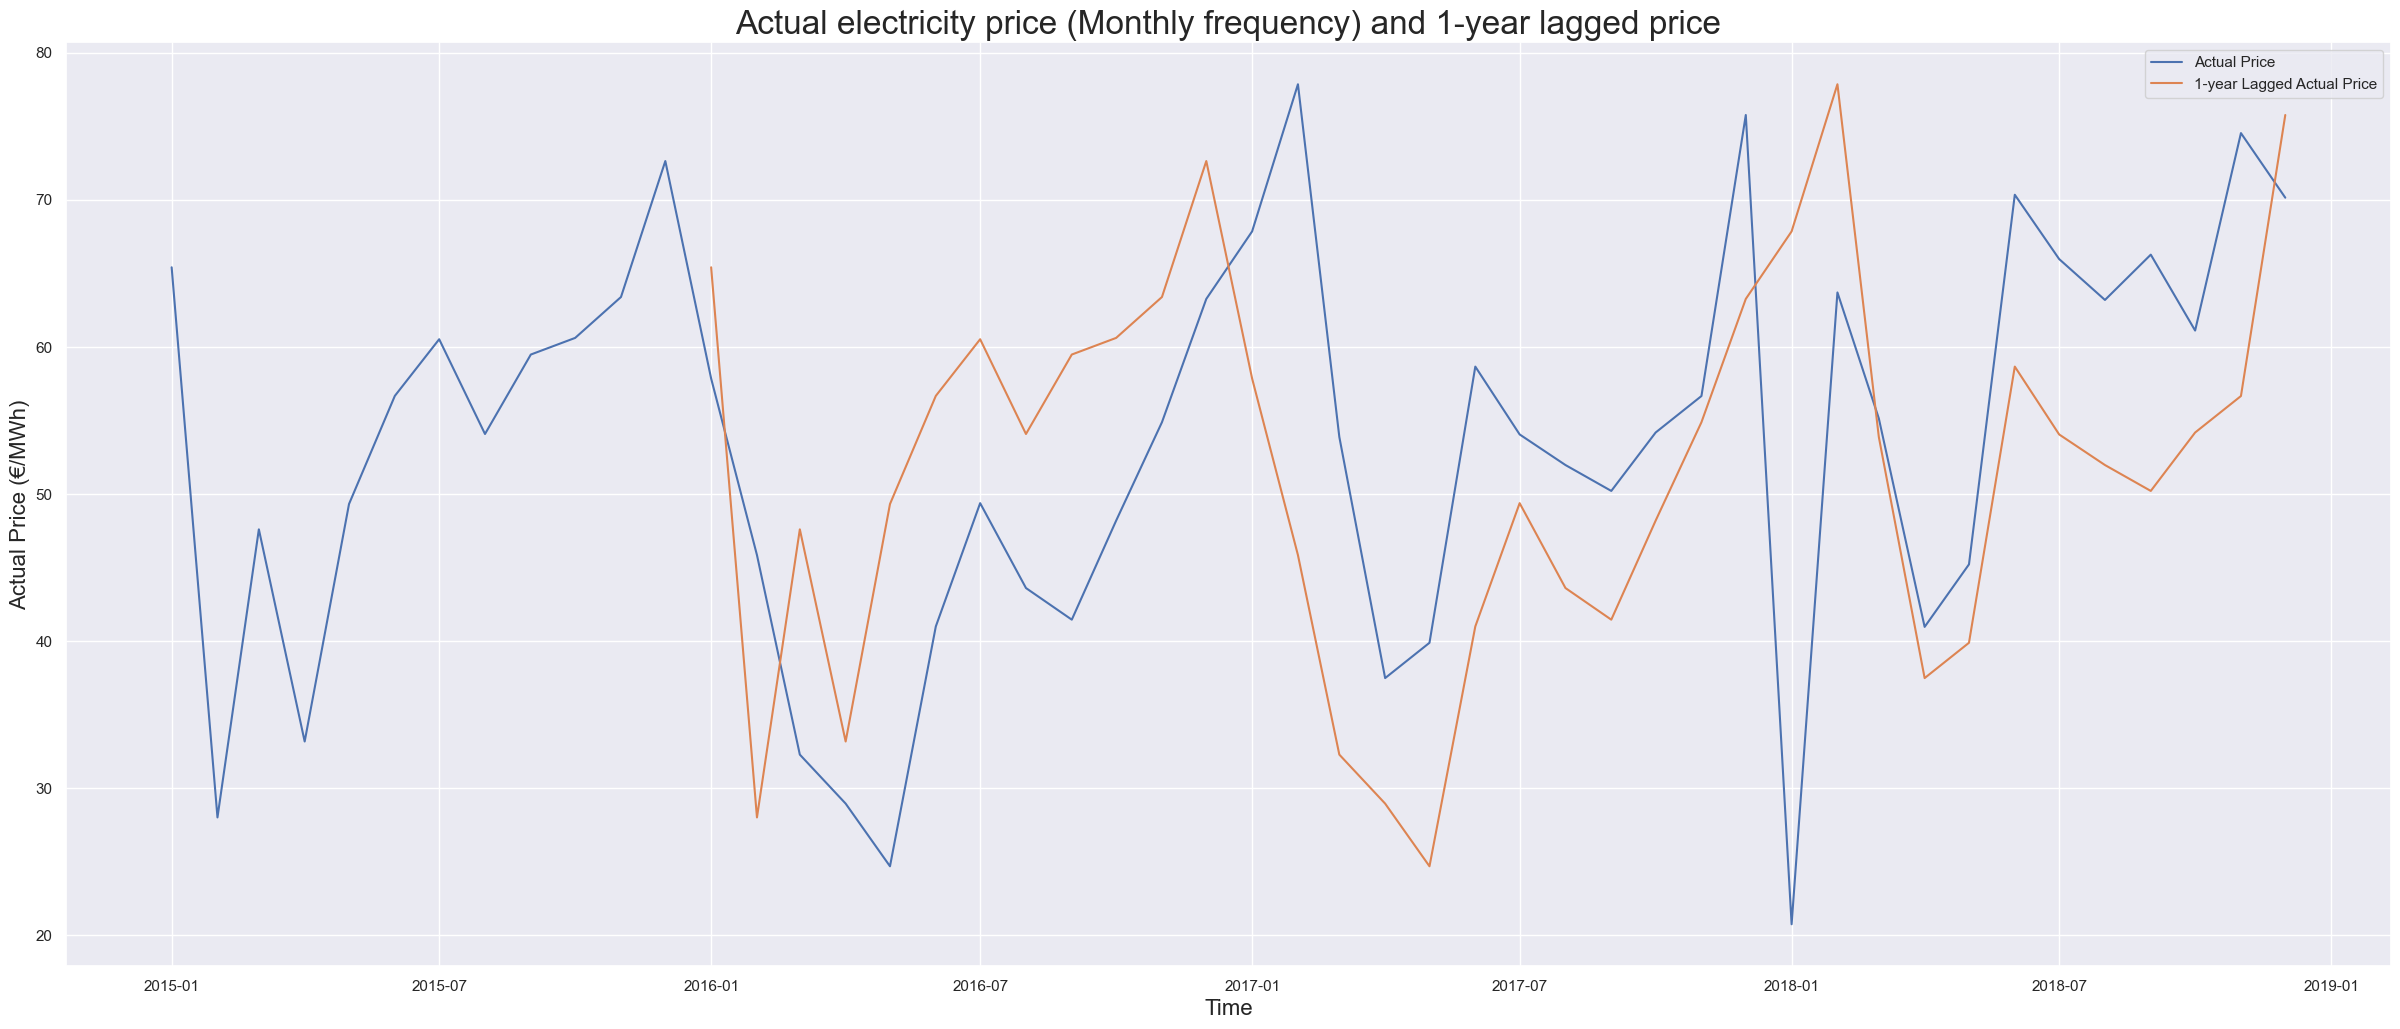

In [21]:
# Plot the electricity price (monthly frequence) along with its 1-year lagged series

monthly_price = df_final['price actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual electricity price (Monthly frequency) and 1-year lagged price')
shifted = df_final['price actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()

The figure above shows the (resampled) monthly frequency of the actual electricity price, along with its 1-year lagged monthly frequency. From this, we can see that there are indeed seasonal patterns at the monthly scale, as certain "spikes" in the time-series take place in exactly the same months. This means that it would be a good idea to create a new feature for the months. If the figure displayed the 1-year lagged actual energy price at hourly or weekly time scales, we would -of course- see no such seasonal patterns.

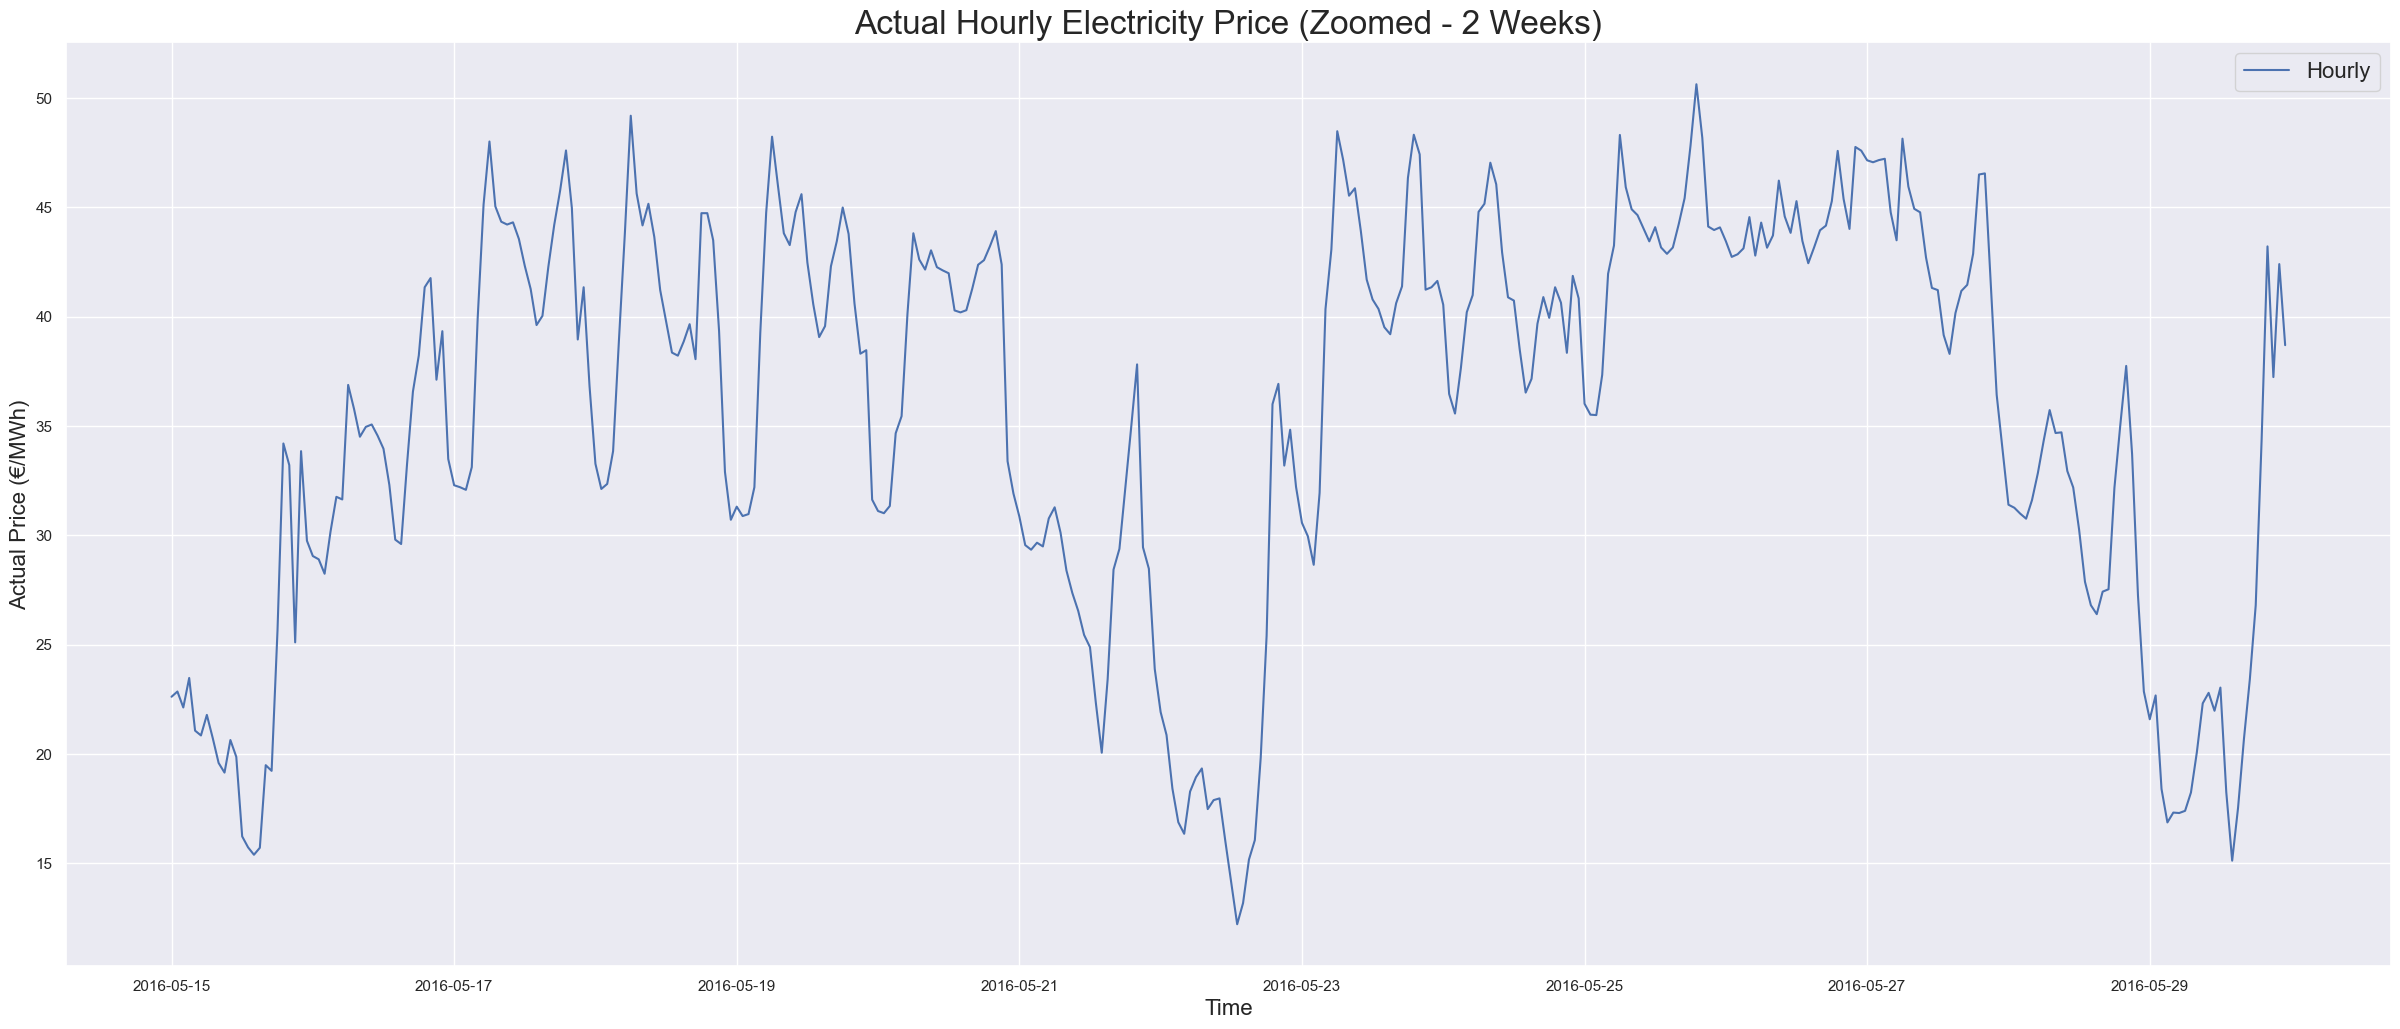

In [22]:
# Plot the actual electricity price at a daily/weekly scale

ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

In the figure above, we have plotted that actual hourly electricity price from 15/06/2016 (Sunday) at 00:00 up to 29/06/2016 (Sunday) at 23:00, i.e. two weeks of data. We can observe that there are many patterns and periodicities, such as:

* A periodicity from week to week, as the electricity price tends to be higher during business days and lower during weekends and especially during sundays.
* An intradyay periodicity, as the price is higher during the day and lower during the night.
* A periodicity within the business hours, as in some cases the electricity price drops for a few hours, which is probably due to "siesta", the traditional lunch break between 01:30PM and 04:30PM, as Spain does not strictly follow the 9AM-5PM business day.

Later on, we will make sure that we will generate features which contain these kinds of information.

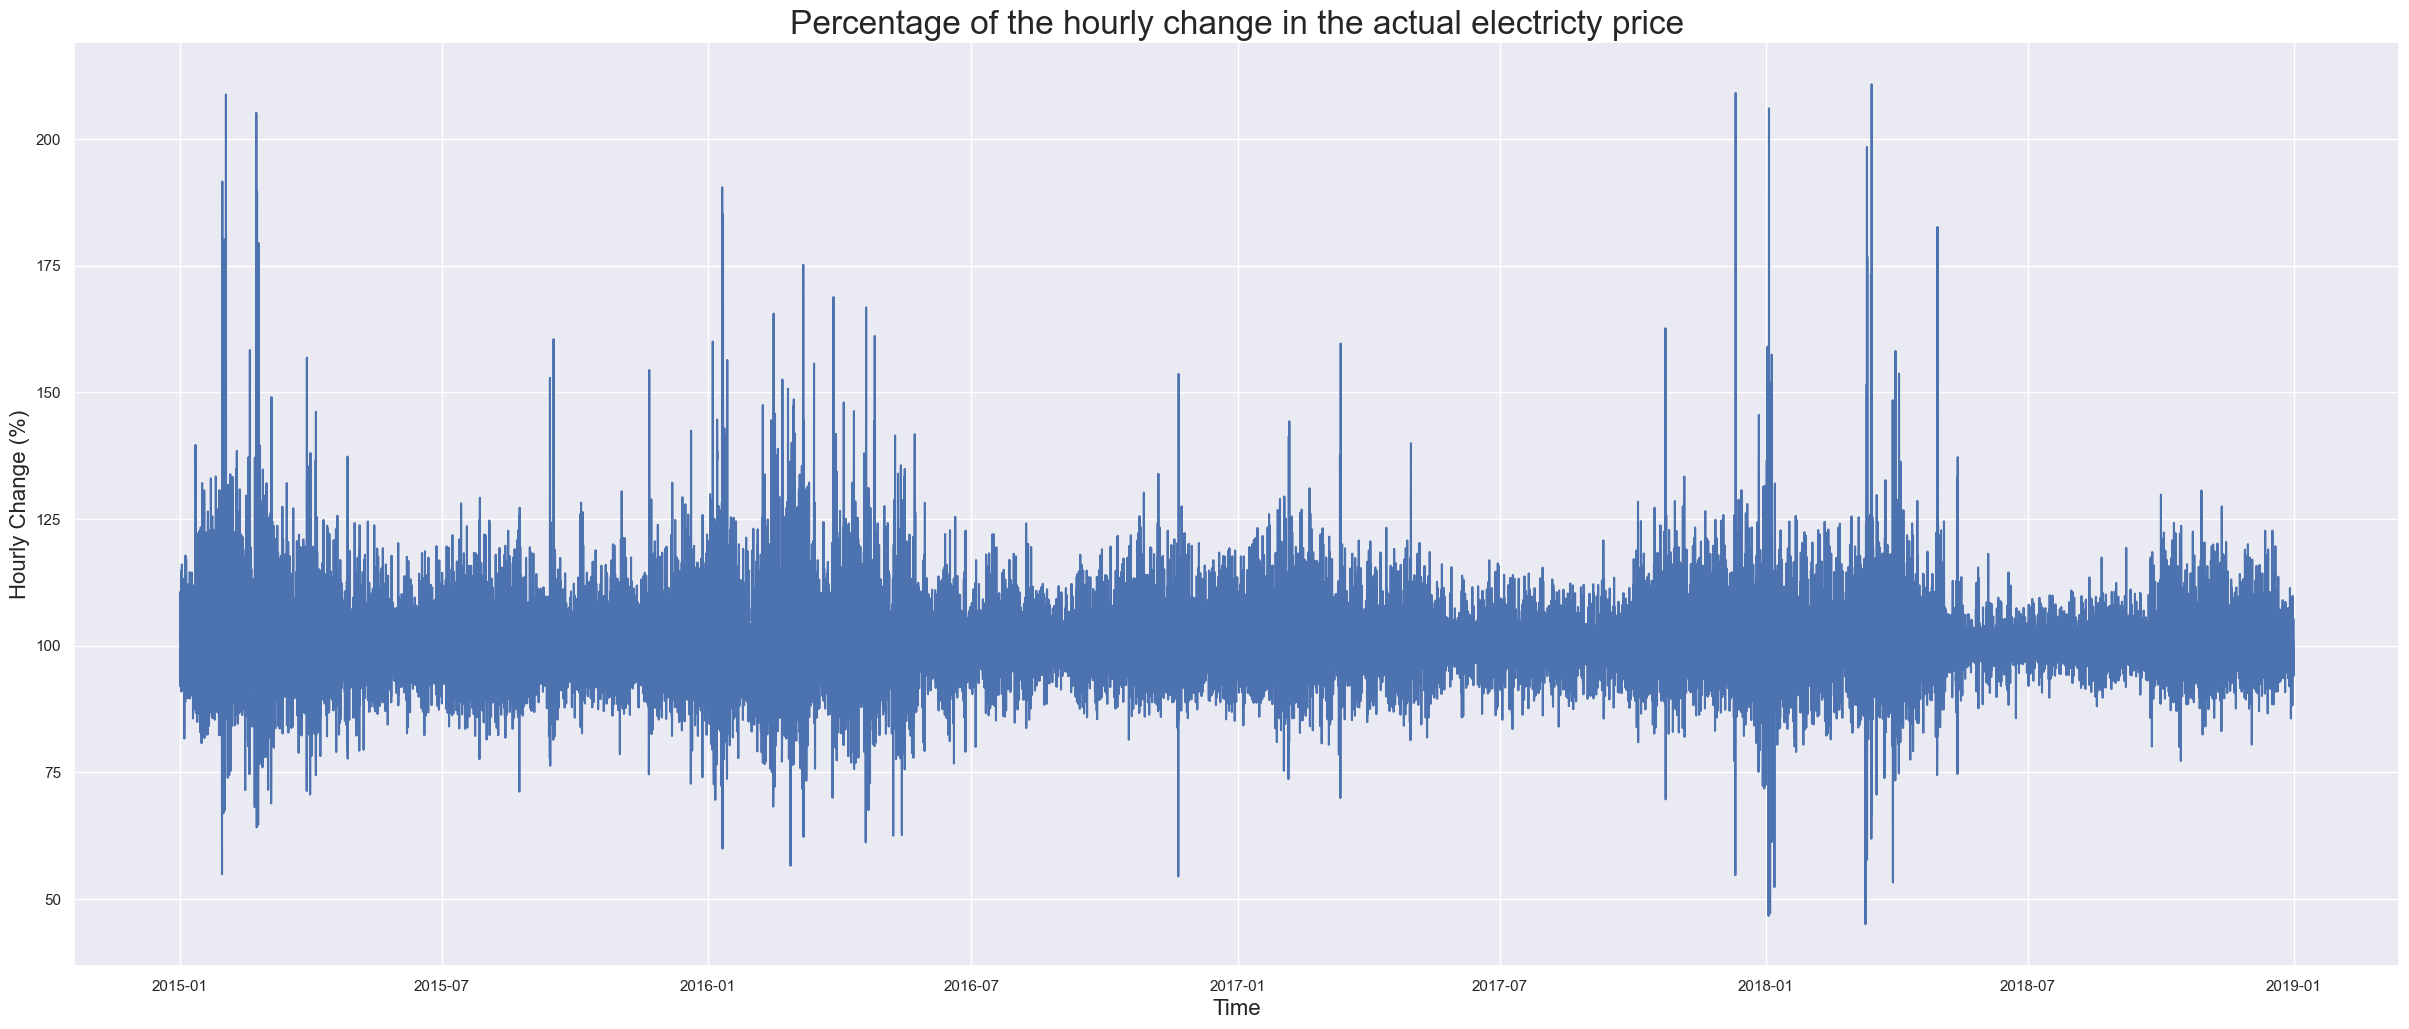

In [23]:
# Plot the percentage of the hourly change in the actual electricity price

change = df_energy['price actual'].div(df_energy['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the actual electricty price')
plt.show()

From the figure above, we can see that the change in the actual price from hour to hour is in most of the cases between -25% (actual price * 0.75) and +25% (actual price * 1.25). However, there are also very few outliers which show that the price gets halved (-50%) or doubled (+100%).

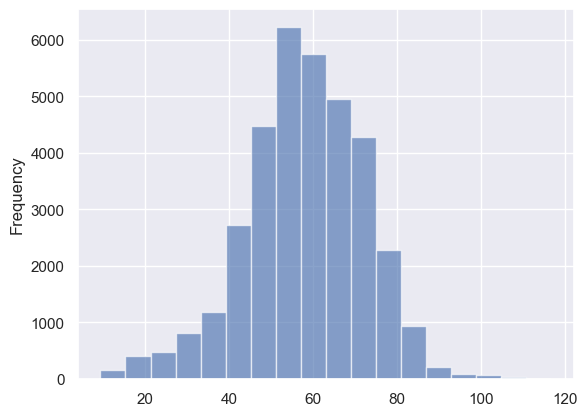

In [24]:
# Plot the histogram of the actual electricity price

ax = df_energy['price actual'].plot.hist(bins=18, alpha=0.65)

In the figure above, we can see that teh actual energy price roughly follows a normal distribution an dthus, could be standardized. However, we also have to make sure that the time series does not require any other kinds of transformations. More specifically, we will check whether th etime series of energy price is stationary, after visualizing its decomposed component time-series.

**2.2. Decomposition and stationarity tests**

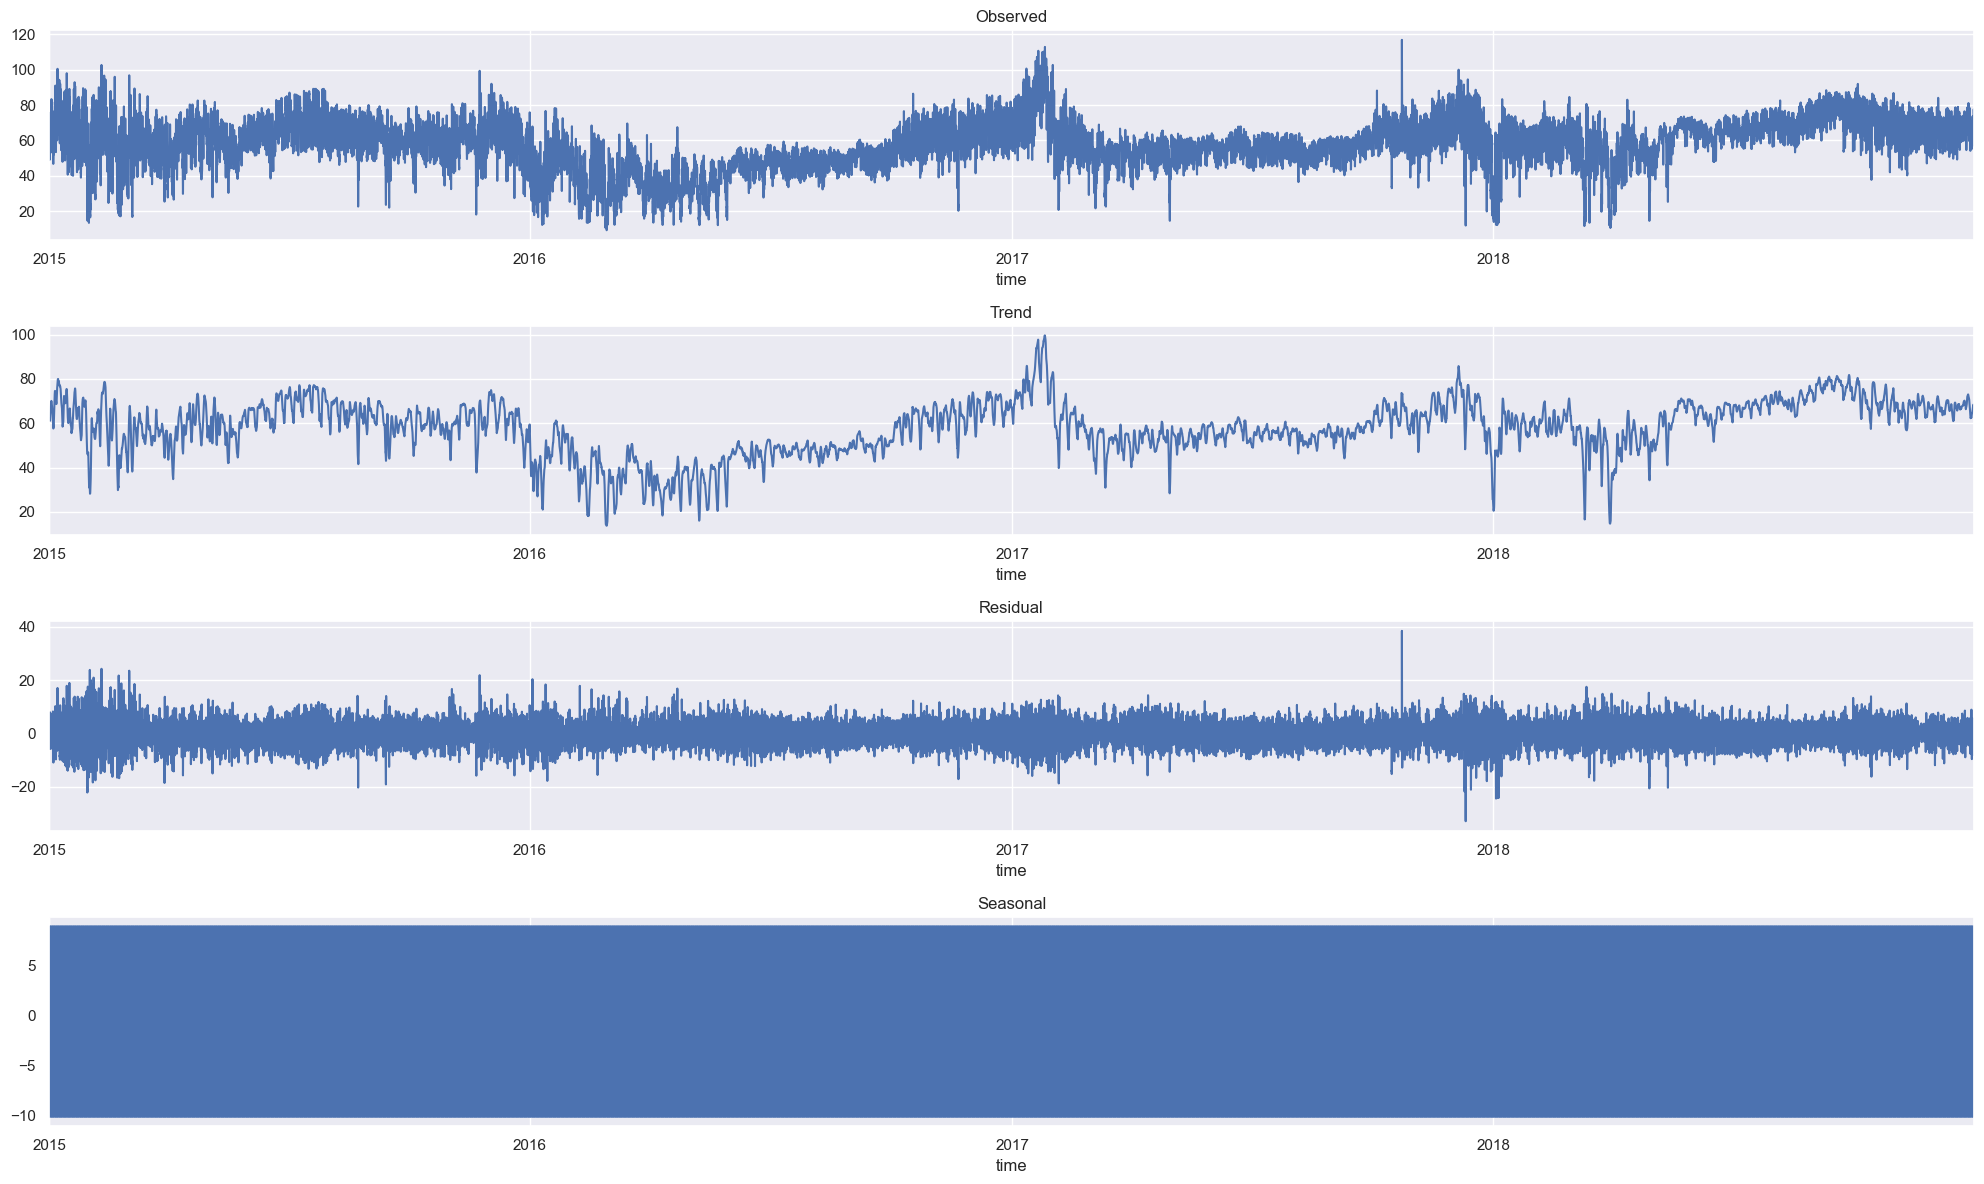

In [25]:
# Decompose the electricity price time series

res = sm.tsa.seasonal_decompose(df_energy['price actual'],
                               model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

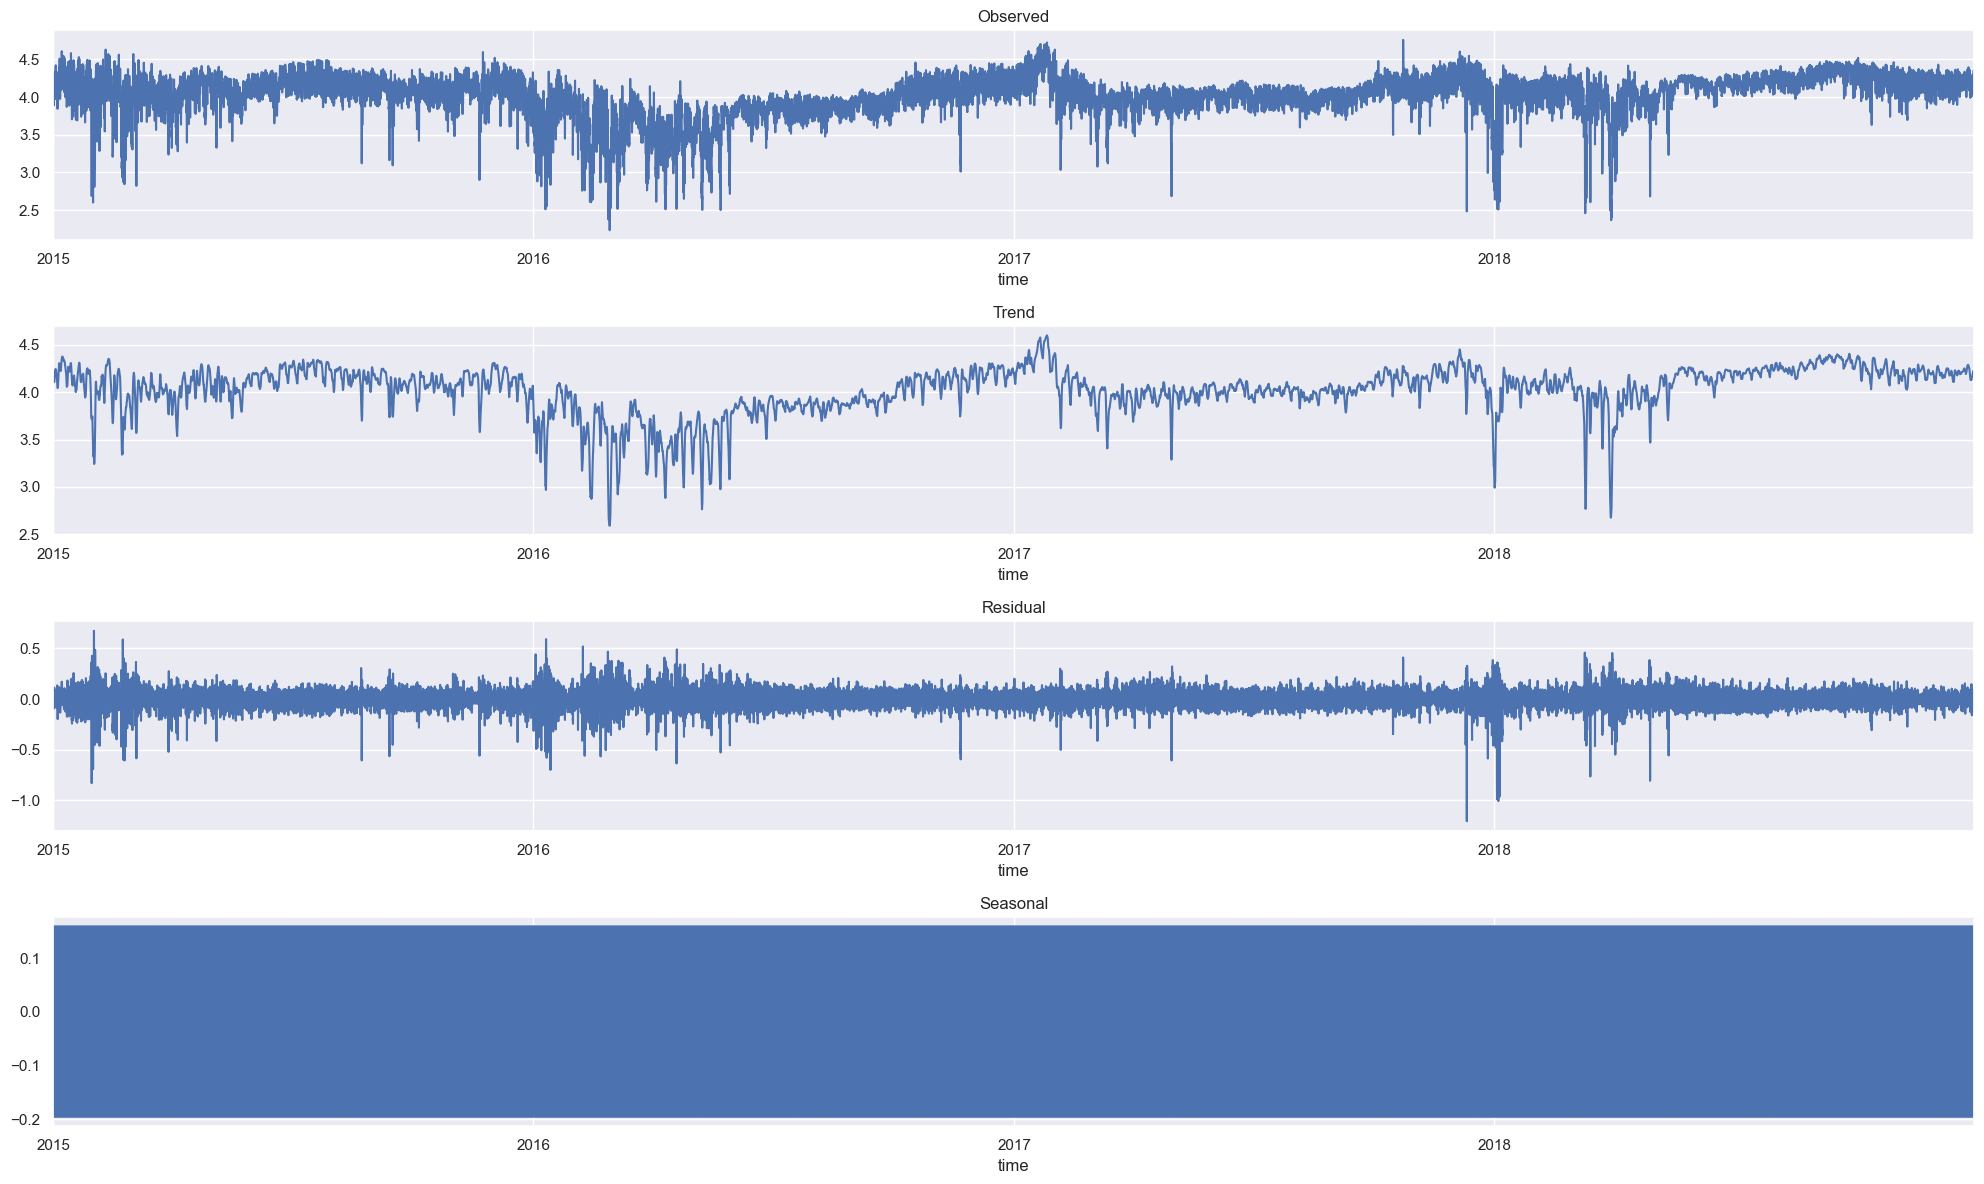

In [26]:
# Decompose the log electricity price time-series

res = sm.tsa.seasonal_decompose(np.log(df_energy['price actual']),
                               model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

The **ADF test**, a type of unit root test, determines how strongly a time series is defined by atrend. Its hypotheses are the following:

* Null Hypothesis H0: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.

* Alternate Hypothesis H1: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [27]:
y = df_final['price actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -9.147016
p-value: 0.000000
#Lags used: 50
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814


The ADF statistic (-9.147) is less than the critical value at 1% (-3.431) and thus, we can say that **we reject the null hypothesis 𝐻0
 with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

The **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**, follows the opposite logic from Augmented Dickey-Fuller test and checks for stationarity. Its hypotheses are the following:

* Null Hypothesis  𝐻0
 : The time series is level, i.e. it is stationary around a constant.
* Alternate Hypothesis  𝐻1
 : There is a unit root in the time series and thus it not stationary.

In [28]:
kpss_test = kpss(y, regression='c')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 4.330034
p-value: 0.010000
#Lags used: 105
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


The KPSS statistic (7.957) is higher than the critical value at 1% (0.739) and thus, we can say that **we cannot reject the null hypothesis 𝐻0
 with a significance level 1%**, meaning that the time series is stationary or stationary around a constant.

Both tests concluded that the electricity price time series is stationary, while it is also true that deep neural networks can handle such properties in a more forgiving way compared to ARIMA models.

**Autocorrelation, partial autocorrelation and cross-correlation**

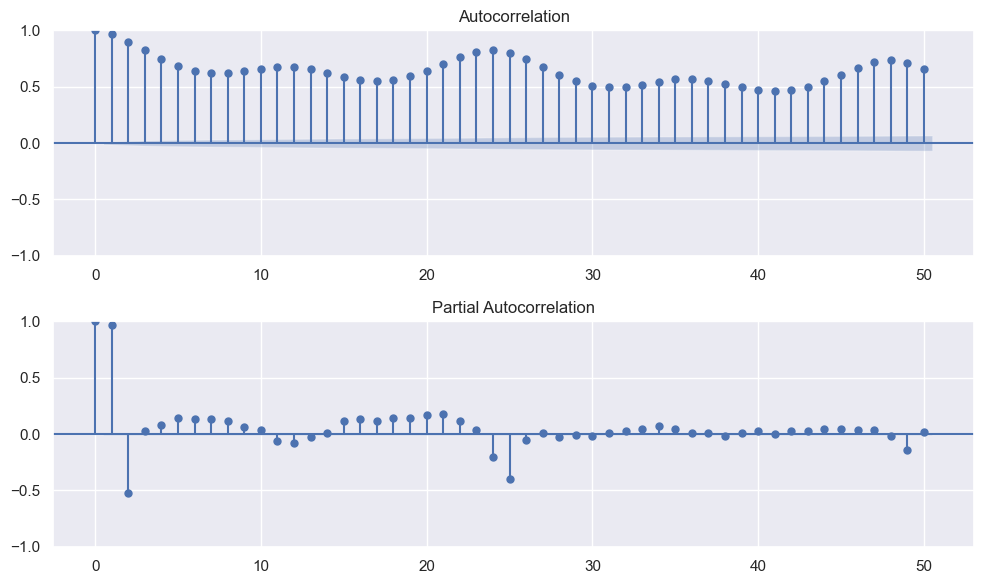

In [29]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_final['price actual'], lags=50, ax=ax1)
plot_pacf(df_final['price actual'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

The partial autocorrelation plot of the eletricity price time series shows that the direct relationship between an observation at a given hour (t) is strongest with the observations at t-1, t-2, t-24 and t-25 time-steps and diminishes afterwards. Thus, we are going to use the 25 previous values of each time series which will constitute a feature for our models.

Nevertheless, it would quite definitely be more beneficial if we only chose to use specific past values (observations at certain time-lags) of a given feature, based on the cross-correlation between the electricity price and each one of the features in the dataset. For example, below we can see the cross-correlation between the electricity price and the total load. We see that there are many time-lags with a correlation which is close to zero and could be ommited.

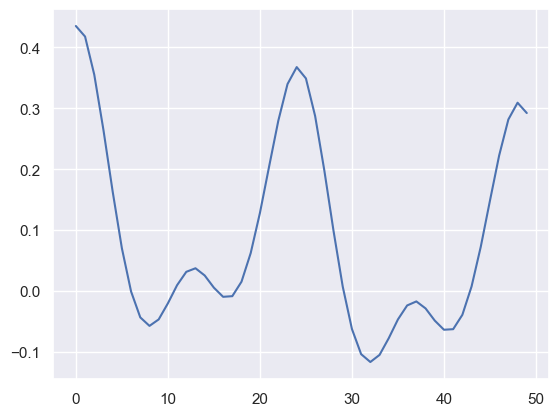

In [30]:
cross_corr = ccf(df_final['total load actual'], df_final['price actual'])
plt.plot(cross_corr[0:50])
plt.show()

For simplicity, we will just work with the correlations between the electricity price and the other features at each given hour.

In [31]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_final.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
generation waste                               0.168710
generation biomass                             0.142671
generation other                               0.099914
generation solar                               0.098529
generation hydro water reservoir               0.071910
generation nuclear                            -0.053016
generation hydro run-of-river and poundage    -0.136659
generation wind onshore                       -0.220497
generation hydro pumped storage consumption   -0.426196


From the above, we can already see some very interesting correlations among the energy price that we want to predict and the rest of the features. For example, the total energy load and the amount of energy generated from sources related to fossil fuels, is positively correlated with the electricity price. In contrast, the wind speed in almost every city and the amount of storage energy cosumed through hydroelectric pumping is negatively correlated with the energy price. We will go ahead and drop the 'snow_3h_Barcelona' and 'snow_3h_Seville' which give NaNs in their correlations with the electricity actual price.

In [33]:
columns_to_drop = ['snow_3h_Barcelona', 'snow_3h_Seville']
df_final = df_final.drop([col for col in columns_to_drop if col in df_final.columns], axis=1)


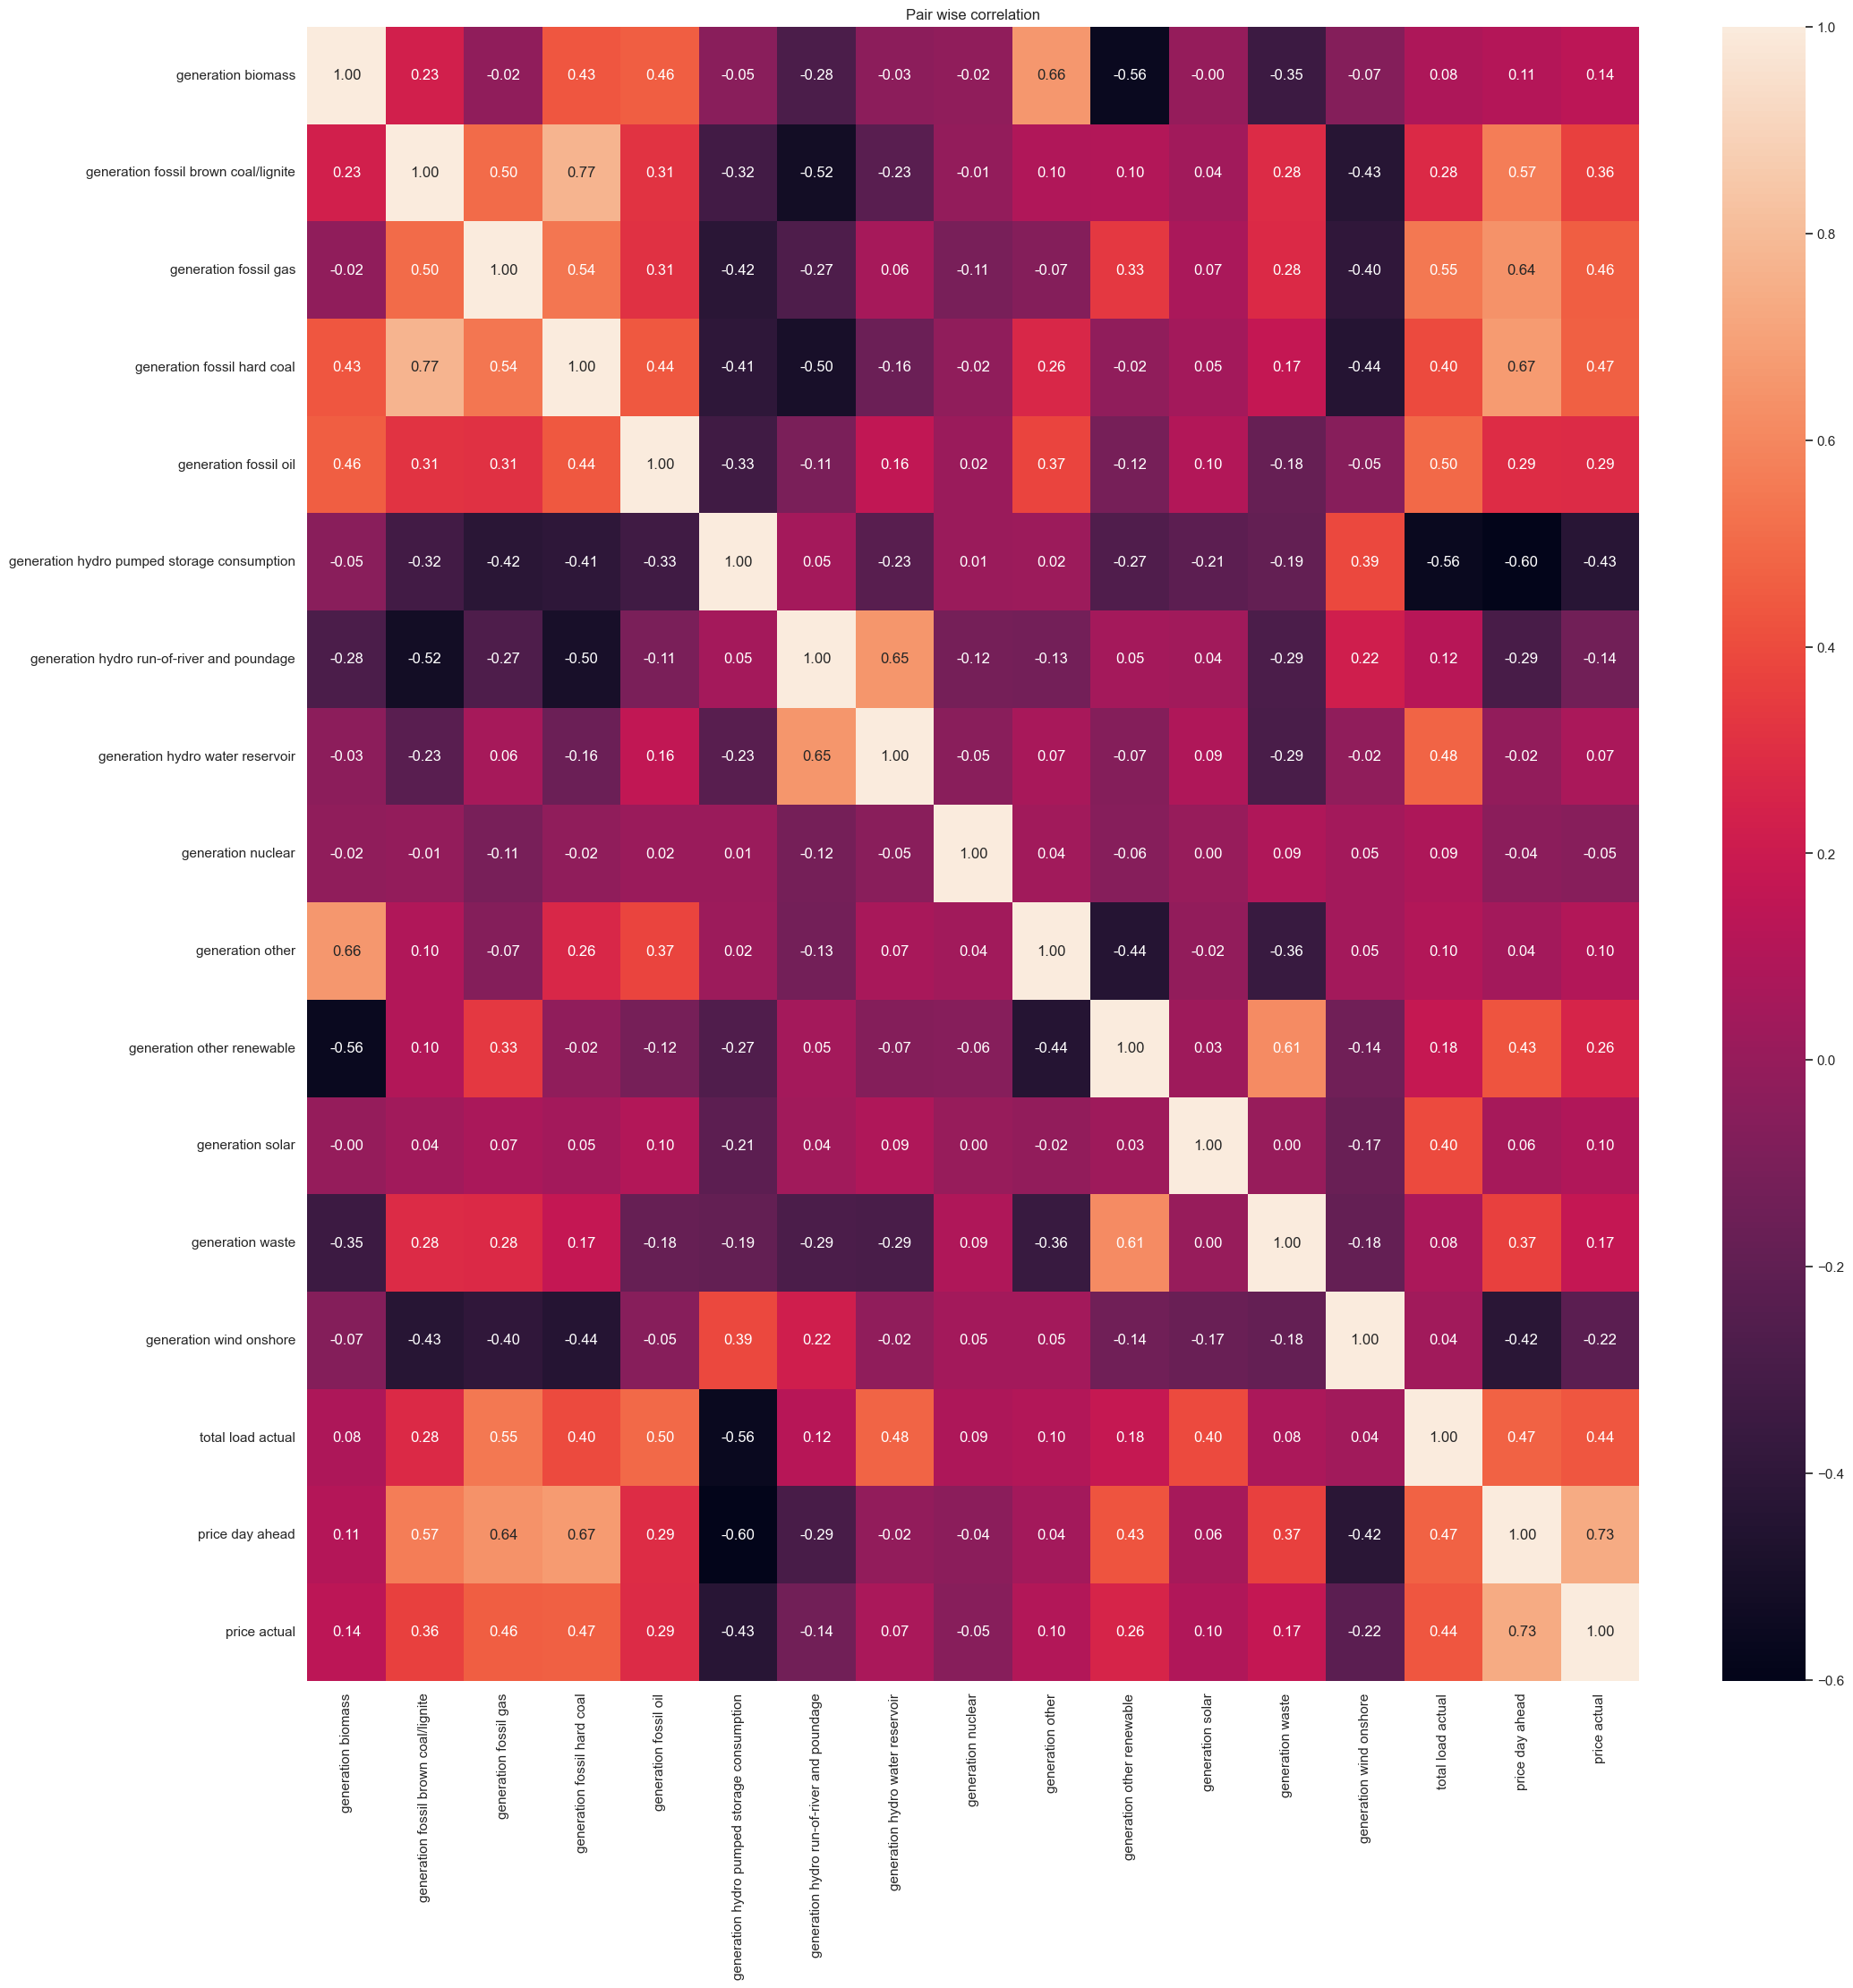

In [34]:
# Plot pair wise correlation matrix

correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24,24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pair wise correlation')
plt.show()

We can observe that tehre are quite a lot of features that are highly correlated with each other.

In [35]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831


Apart frm the amount of energy generated by fossil brown coal/lignit and hard coal, the most correlated feature are associated with temperatures among different cities, as well as the "secondary" information we have about the temperature of each individual city (i.e. the minimum and maximum temperature).

**Feature Engineering**

**Feature generation**

The first features that we will generate for a given hour will just be that particular hour, the day and the month in which it falls into.

In [36]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

A very useful feature that we will generate, has to do with the business hours, i.e. whether businesses are open or not in a given hour. However, there is a certain peculiarity in Spain as the 9AM-5PM working day is not generally followed by all types of businesses, due to a lunch break (known as "siesta") in between. The most usual business hours are from Monday-Saturday, from 9:30AM-1:30PM and then again from 4:30PM-8PM.

Therefore, the value of the 'business hour' will be equal to '2' if th egiven hour is within the business hours, equal to '1' if th egiven hour is within the 'siesta' in between and equal to '0' for all other given hours.

In [37]:
# Generate 'business hour' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

However, we have generated the 'business hour' feature in such a way which also includes weekends, on which fewer -or different types of- businesses are open. Thus, it is useful to also generate another feature, 'weekend', which will distuingish weekdays and weekends, as well as make a distinction between Saturdays and Sundays.

In particular, for a particular given hour, the value of 'weekend' will be equal to '0', if the hours is in a weekday, equal to '1' if the hour is in a Saturday and equal to '2' if the hour is in a Sunday.

In [38]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In order to reduce the dimensionality and potentially acquire a new kind of information, for every given hour, we will subtract the minimum temperature ('temp_min') from the maximum temperature ('temp_max') for each city and we will name that feature 'temprange{name of city}'.

In [46]:
# Generate 'temp_range' for each city

cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

# Check if the columns exist
missing_columns = [f'temp_max_{city}' for city in cities if f'temp_max_{city}' not in df_final.columns] + \
                  [f'temp_min_{city}' for city in cities if f'temp_min_{city}' not in df_final.columns]

if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    for i in range(len(df_final)):
        position = df_final.index[i]
        for city in cities:
            temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
            temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
            df_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)


Missing columns: ['temp_max_Barcelona', 'temp_max_Bilbao', 'temp_max_Madrid', 'temp_max_Seville', 'temp_max_Valencia', 'temp_min_Barcelona', 'temp_min_Bilbao', 'temp_min_Madrid', 'temp_min_Seville', 'temp_min_Valencia']


After seeing that there is a high correlation among the temperatures of the different cities, we will also try creating a weighted temperature features by taking into account each city's population.

* Madrid: 6,155,116
* Barcelona: 5,179,243
* Valencia: 1,645,342
* Seville: 1,305,342
* Bilbao: 987,000

In [47]:
# Calculate the weight of every city

total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop

In [48]:
cities_weights = {'Madrid': weight_Madrid,
                 'Barcelona': weight_Barcelona,
                 'Valencia': weight_Valencia,
                 'Seville': weight_Seville,
                 'Bilbao': weight_Bilbao}

In [50]:
# Generate 'temp_weighted' feature

# Check if the columns exist
missing_columns = [f'temp_{city}' for city in cities if f'temp_{city}' not in df_final.columns]

if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    for i in range(len(df_final)):
        position = df_final.index[i]
        temp_weighted = 0
        for city in cities:
            temp = df_final.loc[position, 'temp_{}'.format(city)]
            temp_weighted += temp * cities_weights.get('{}'.format(city))
        df_final.loc[position, 'temp_weighted'] = temp_weighted


Missing columns: ['temp_Barcelona', 'temp_Bilbao', 'temp_Madrid', 'temp_Seville', 'temp_Valencia']


We will also generate a new feature which aggregates both energy sources which are related to coal and are highly correlated (0.7688).

In [51]:
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

**Feature Selection**

In [52]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [53]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [54]:
X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)

In [55]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [56]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [57]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [58]:
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

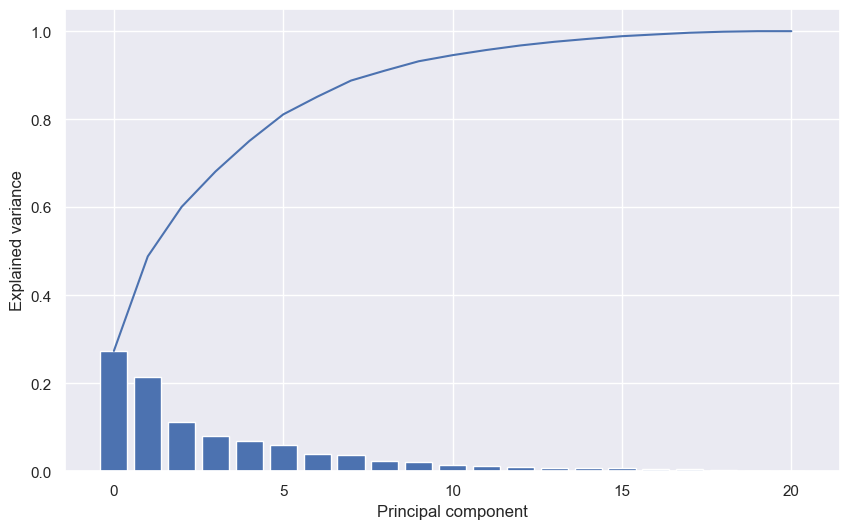

In [59]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [60]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [61]:
X_pca.shape

(35064, 6)

In [62]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

In [63]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

In [64]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)

In [65]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [66]:
batch_size = 32
buffer_size = 1000

In [67]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [68]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [69]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

**Electricity Price Forecasting**

In [70]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

**Naive Forecast**

**XGBoost**

In [71]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [72]:
param = {'eta': 0.03, 'max_depth': 180, 
         'subsample': 1.0, 'colsample_bytree': 0.95, 
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)
eval_list = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(param, dtrain, 180, eval_list, early_stopping_rounds=3)

[0]	train-rmse:0.12944	eval-rmse:0.10908
[1]	train-rmse:0.12580	eval-rmse:0.10599
[2]	train-rmse:0.12227	eval-rmse:0.10303
[3]	train-rmse:0.11885	eval-rmse:0.10012
[4]	train-rmse:0.11553	eval-rmse:0.09733
[5]	train-rmse:0.11233	eval-rmse:0.09463
[6]	train-rmse:0.10922	eval-rmse:0.09203
[7]	train-rmse:0.10621	eval-rmse:0.08951
[8]	train-rmse:0.10330	eval-rmse:0.08708
[9]	train-rmse:0.10047	eval-rmse:0.08471
[10]	train-rmse:0.09774	eval-rmse:0.08242
[11]	train-rmse:0.09509	eval-rmse:0.08021
[12]	train-rmse:0.09253	eval-rmse:0.07809
[13]	train-rmse:0.09005	eval-rmse:0.07601
[14]	train-rmse:0.08766	eval-rmse:0.07403
[15]	train-rmse:0.08534	eval-rmse:0.07213
[16]	train-rmse:0.08309	eval-rmse:0.07023
[17]	train-rmse:0.08093	eval-rmse:0.06844
[18]	train-rmse:0.07883	eval-rmse:0.06672
[19]	train-rmse:0.07691	eval-rmse:0.06526
[20]	train-rmse:0.07494	eval-rmse:0.06364
[21]	train-rmse:0.07304	eval-rmse:0.06210
[22]	train-rmse:0.07121	eval-rmse:0.06061
[23]	train-rmse:0.06944	eval-rmse:0.05918
[2

In [73]:
forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

rmse_xgb = sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
print('RMSE of hour-ahead electricity price XGBoost forecast: {}'
      .format(round(rmse_xgb, 3)))

RMSE of hour-ahead electricity price XGBoost forecast: 2.217


**LSTM**

In [77]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.keras', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [78]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1253 - root_mean_squared_error: 0.2800 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672
Epoch 2/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 3/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 4/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 5/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 7.2648e-04 - val_root_mean_squared_error: 0.0270
Epoch 6/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 9.8222e-04 - val_root_mean_squared_error: 0.0313
Epoch 7/120
845/845 ━━━━━━━━━━━━━━━━━━

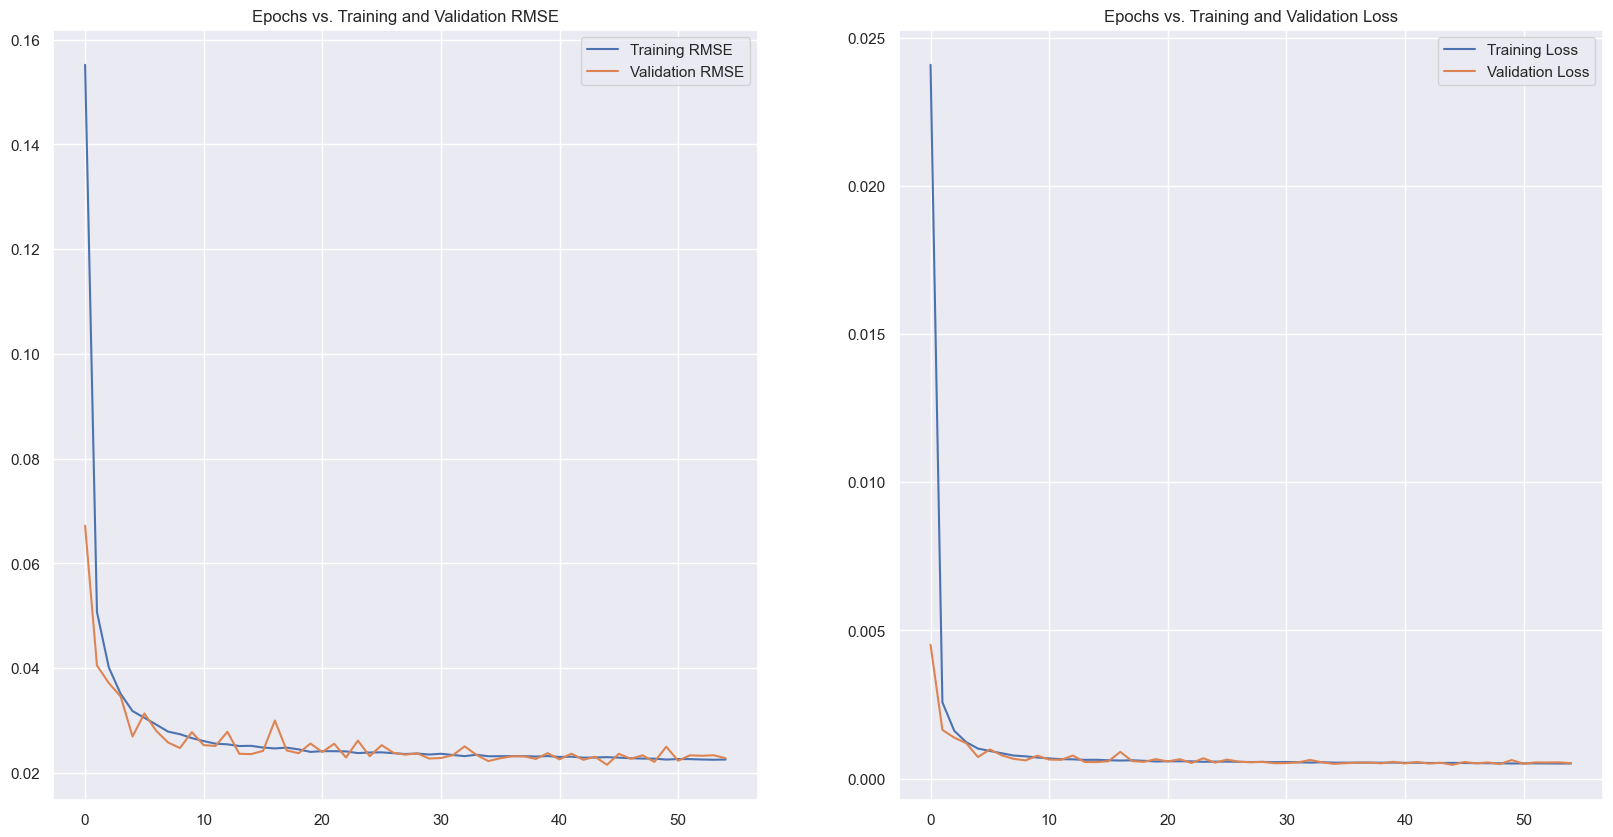

In [79]:
plot_model_rmse_and_loss(history)

In [81]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.keras')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead electricity price LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE of hour-ahead electricity price LSTM forecast: 1.99


**Stacked LSTM**

In [85]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.keras', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [86]:
history = multivariate_stacked_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.0436 - root_mean_squared_error: 0.1293 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 2/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0037 - root_mean_squared_error: 0.0601 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 3/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0027 - root_mean_squared_error: 0.0514 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 4/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 5/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 6/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 7.0115e-04 - val_root_mean_squared_error: 0.0265
Epoch 7/120
845/845 ━━━━━━━━━━

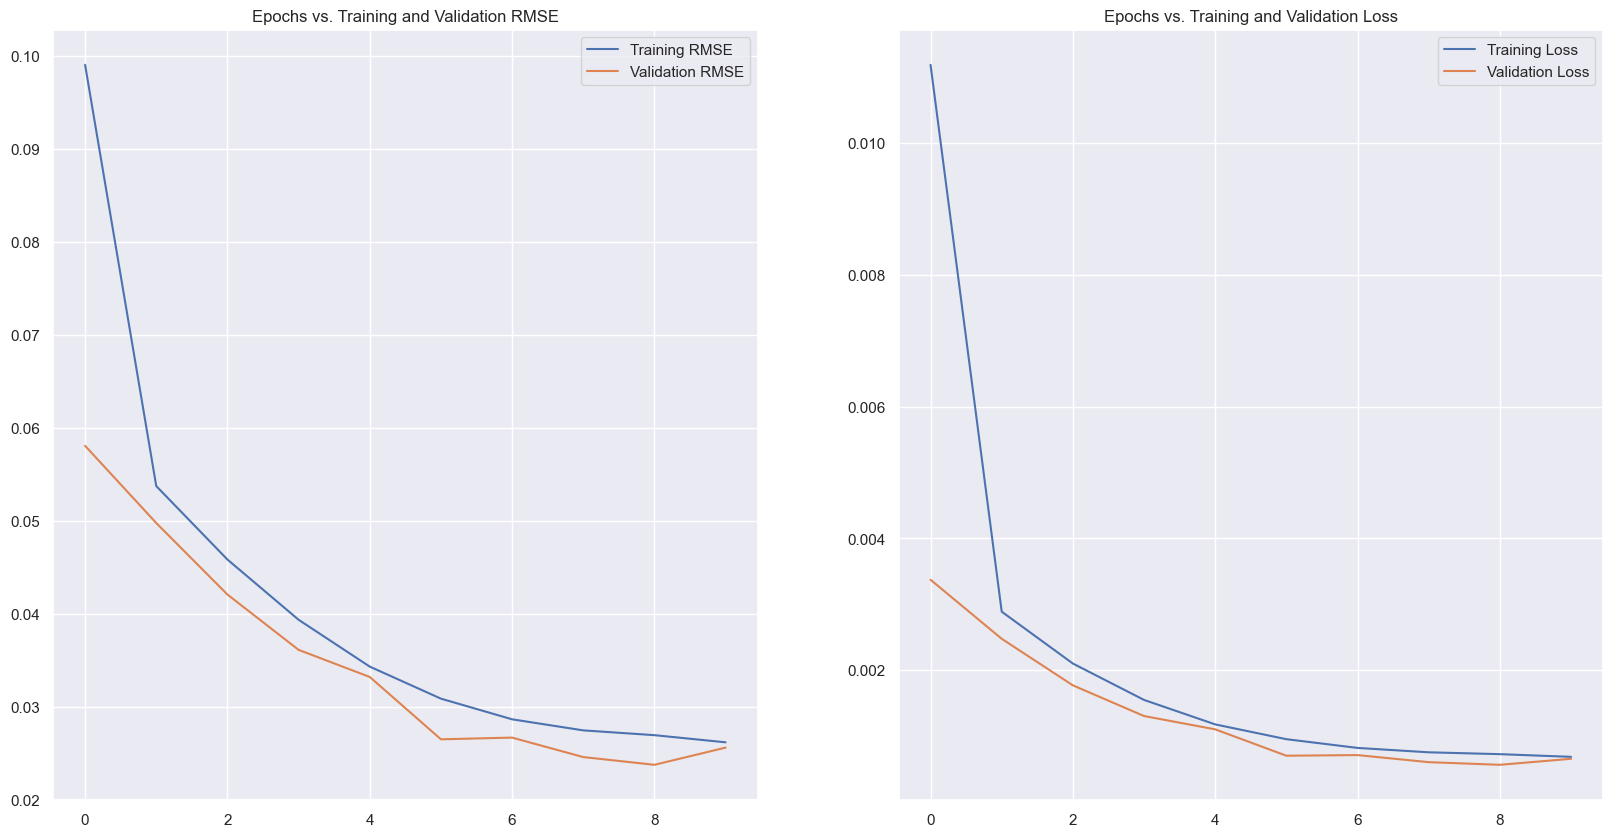

In [87]:
plot_model_rmse_and_loss(history)

In [89]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.keras')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv, 
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: 2.233


**CNN**

In [92]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.keras', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [93]:
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - loss: 0.1371 - root_mean_squared_error: 0.2424 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 2/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - loss: 0.0151 - root_mean_squared_error: 0.1226 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 3/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - loss: 0.0150 - root_mean_squared_error: 0.1220 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 4/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step - loss: 0.0149 - root_mean_squared_error: 0.1217 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 5/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - loss: 0.0148 - root_mean_squared_error: 0.1212 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 6/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - loss: 0.0149 - root_mean_squared_error: 0.1216 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 7/120
845/845 ━━━━━━━━━━━━━━

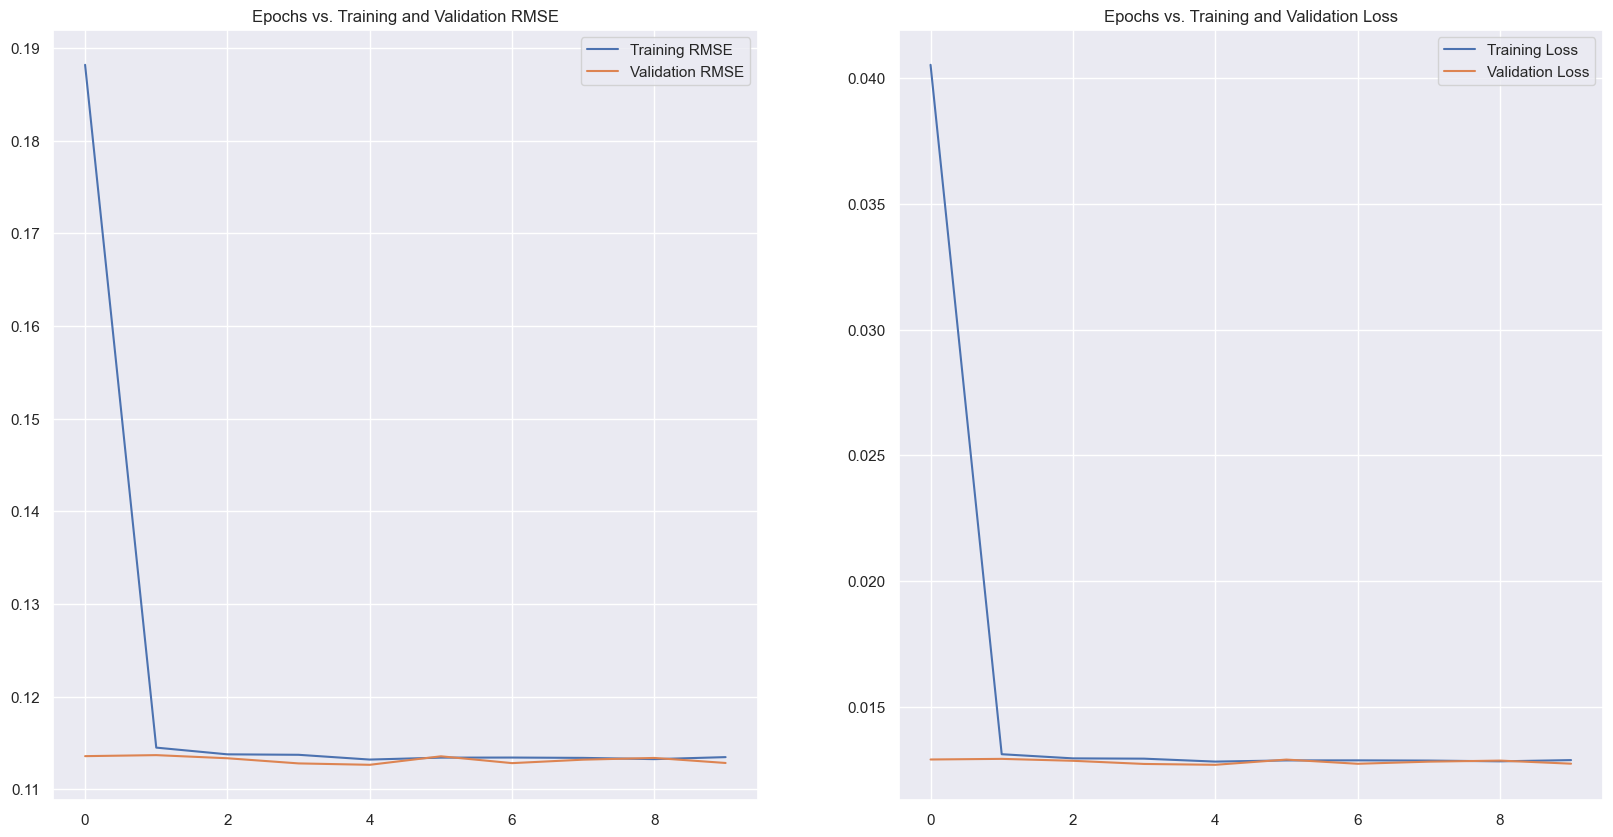

In [94]:
plot_model_rmse_and_loss(history)

In [96]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.keras')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
RMSE of hour-ahead electricity price multivariate CNN forecast: 12.945


**CNN-LSTM**

In [98]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.keras', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [99]:
history = multivariate_cnn_lstm.fit(train, epochs=120,
                                    validation_data=validation,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

Epoch 1/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0646 - root_mean_squared_error: 0.1584 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548
Epoch 2/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0021 - root_mean_squared_error: 0.0450 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 3/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414
Epoch 4/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 5/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 9.8020e-04 - root_mean_squared_error: 0.0311 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 6/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 8.6580e-04 - root_mean_squared_error: 0.0293 - val_loss: 9.1945e-04 - val_root_mean_squared_error: 0.0303
Epoch 7/120
845/845 ━━━━━━━━━━━━━━

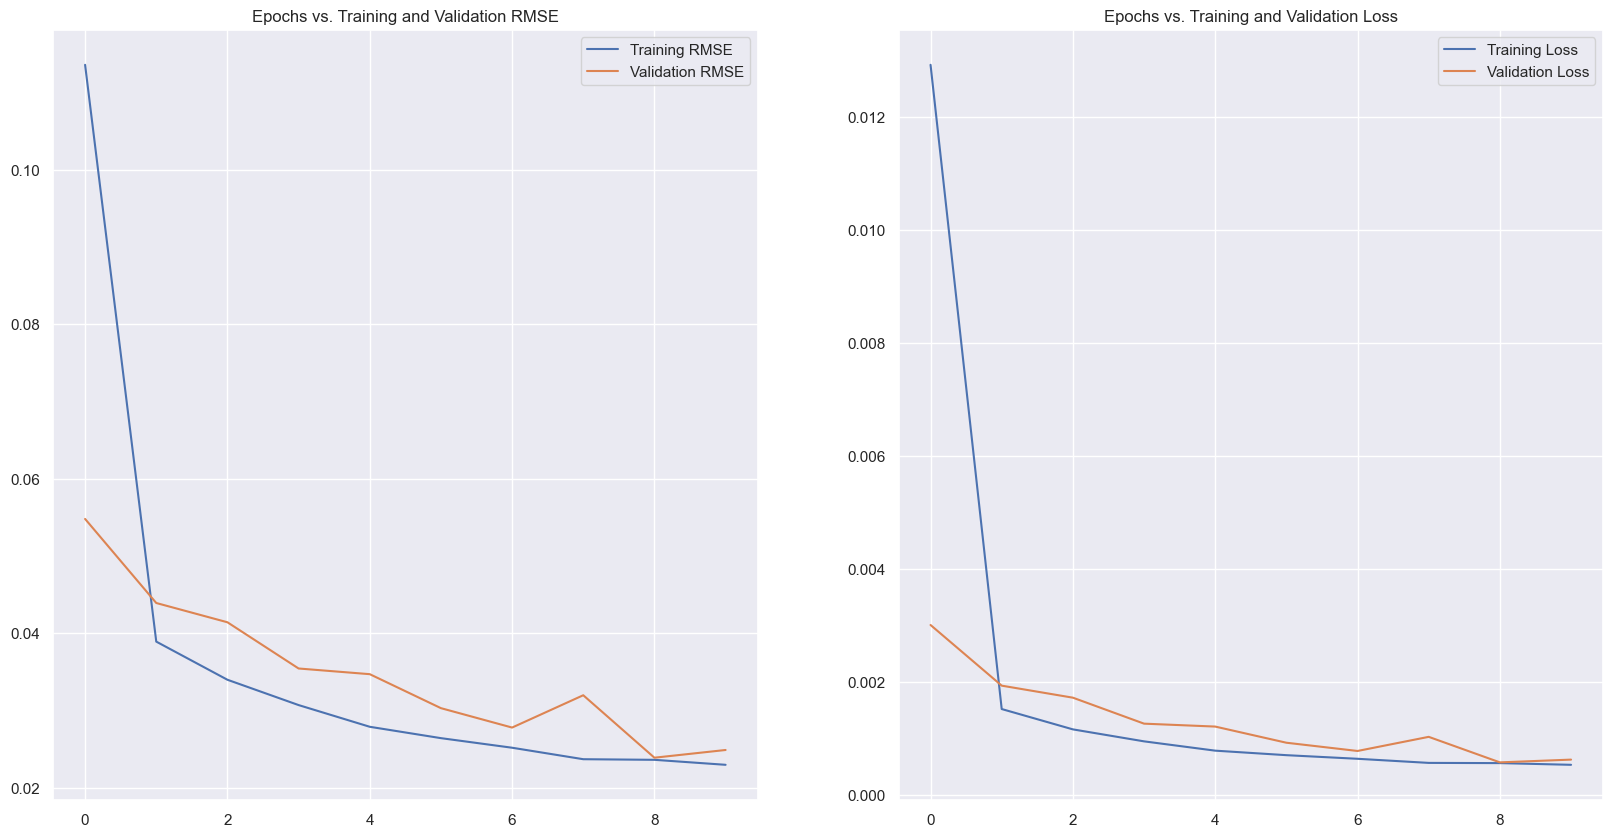

In [100]:
plot_model_rmse_and_loss(history)

In [102]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.keras')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv, 
                                             multivariate_cnn_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN-LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE of hour-ahead electricity price multivariate CNN-LSTM forecast: 2.22


In [103]:
X_test.shape

(3984, 24, 7)

**Time Distributed MLP**

In [105]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.keras', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [106]:
history = multivariate_mlp.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0110 - root_mean_squared_error: 0.0700 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 2/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 9.6218e-04 - val_root_mean_squared_error: 0.0310
Epoch 3/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 6.3499e-04 - val_root_mean_squared_error: 0.0252
Epoch 4/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 6.8291e-04 - val_root_mean_squared_error: 0.0261
Epoch 5/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0316 - val_loss: 5.8400e-04 - val_root_mean_squared_error: 0.0242
Epoch 6/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 9.1093e-04 - root_mean_squared_error: 0.0301 - val_loss: 6.6367e-04 - val_root_mean_squared_error: 0.0258
Epoch 7/120
845/845 ━━

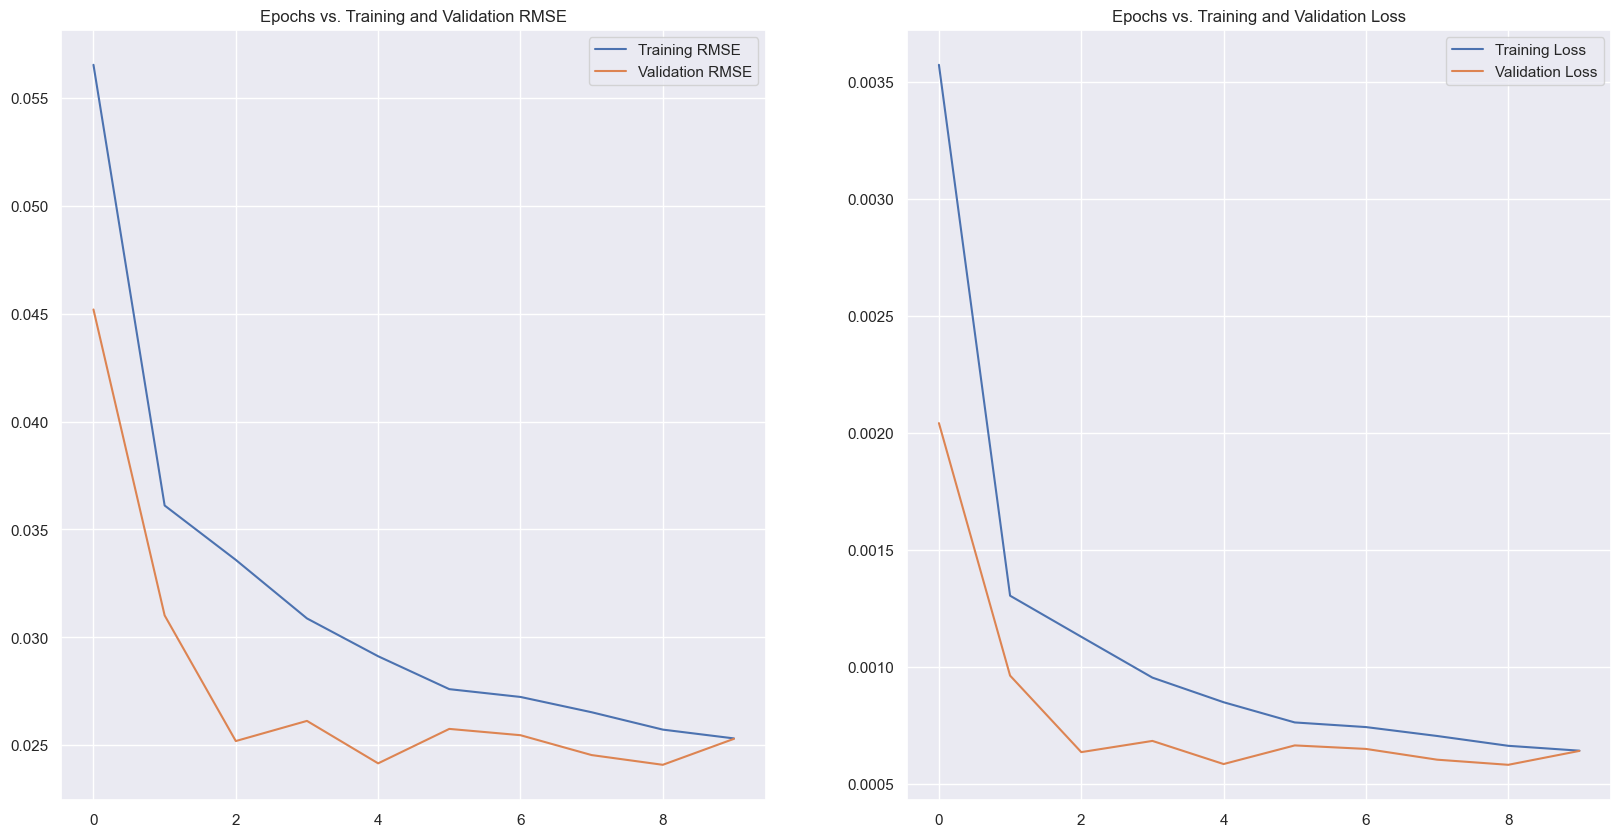

In [107]:
plot_model_rmse_and_loss(history)

In [109]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.keras')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE of hour-ahead electricity price multivariate MLP forecast: 2.356


**Encoder-Decoder**

In [112]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.keras', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

In [113]:
history = encoder_decoder.fit(train, epochs=50,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0137 - root_mean_squared_error: 0.0785 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0474
Epoch 2/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 3/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0339
Epoch 4/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 7.2467e-04 - val_root_mean_squared_error: 0.0269
Epoch 5/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 9.6066e-04 - root_mean_squared_error: 0.0308 - val_loss: 6.9593e-04 - val_root_mean_squared_error: 0.0264
Epoch 6/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 8.2268e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 7/50
845/845 ━━━━━━━━━━━━━━━━━

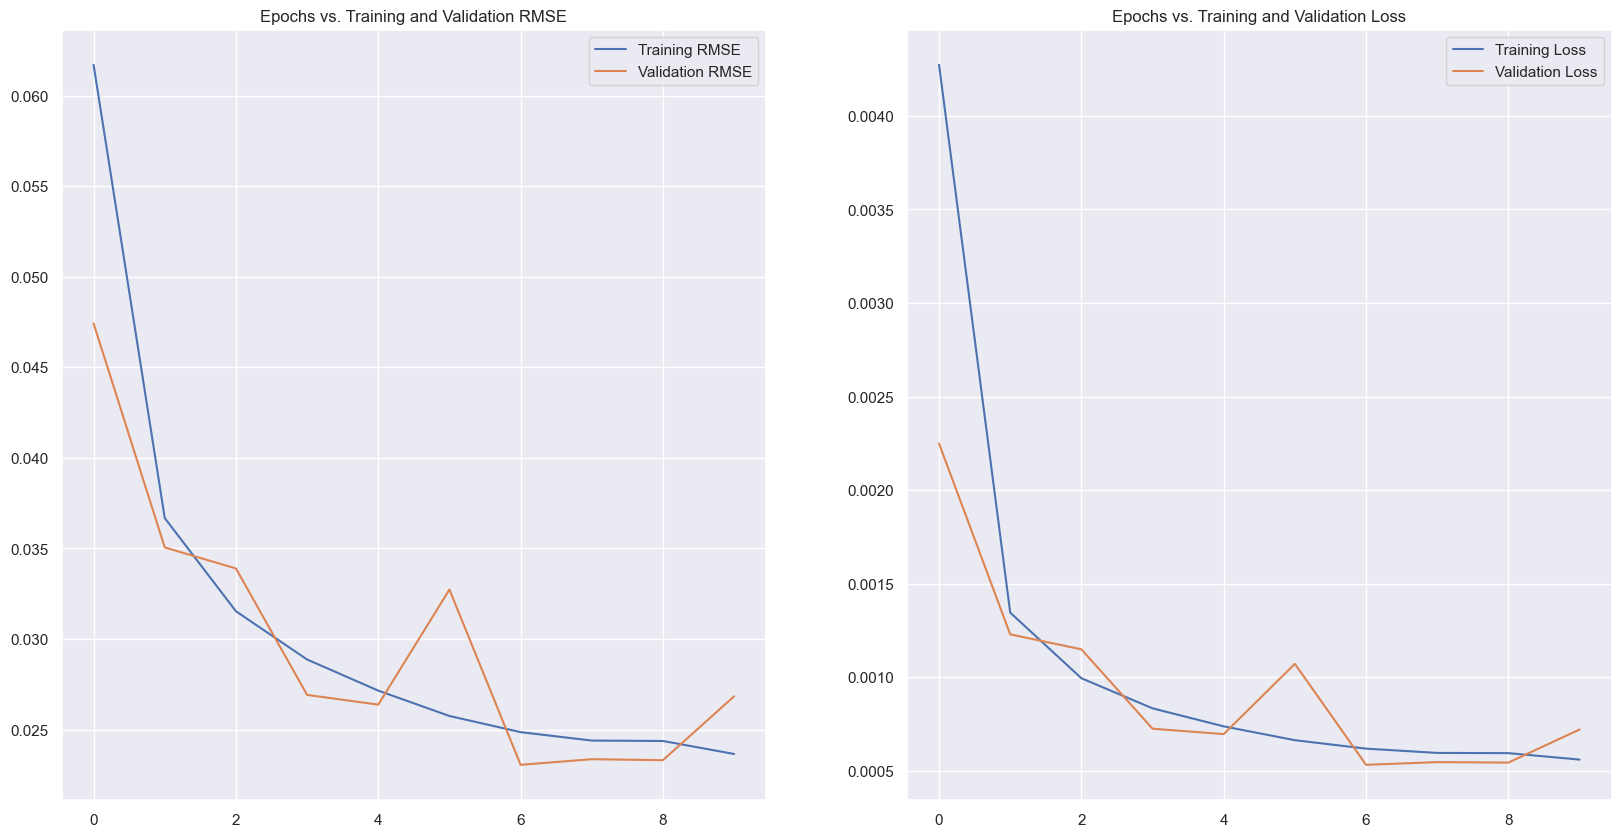

In [114]:
plot_model_rmse_and_loss(history)

In [116]:
encoder_decoder = tf.keras.models.load_model('encoder_decoder.keras')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv, 
                                               encoder_decoder_forecast))
print('RMSE of hour-ahead electricity price Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE of hour-ahead electricity price Encoder-Decoder forecast: 2.236
